In [2]:
#!pip install kmodes
#!pip install yellowbrick

## Importing Packages

In [3]:
# Suppressing warnings
import warnings
warnings.filterwarnings('ignore');

# Libraries for data manipulation/management
import numpy as np
import pandas as pd

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Libraries for clustering
from scipy.stats import norm, zscore
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from kmodes.kprototypes import KPrototypes

# Setting the theme and fontsize of figures
sns.set_theme(style = 'darkgrid', font_scale = 1.13)
# Restricting the float value of a dataframe to 3 decimal points
pd.set_option('display.float_format', lambda x: '%.2f' % x)
# Removing the limit for the number of displayed columns in a dataframe
pd.set_option("display.max_columns", None)

# Mounting the drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Loading and General Overview of the Dataset 

In [4]:
# Reading the dataset
data_orig = pd.read_csv('/content/drive/MyDrive/Python_files/Personalization_CS_data.csv', 
                        encoding = 'latin-1')
# Ensuring the original data remains untouched
df = data_orig.copy()

In [5]:
# Viewing the first few rows
df.head()

,Cruise Embark Date,Age Banding,Cruise Ship Name,SubTrade,Lifestage,Lead Time (Days),Mosaic Group,Mosaic Type,Net Weekly HH Income,Total Children,Faretype,Cabin Meta,Cruise Experience,Cruises Completed with HAL,Region,Contactability,Duration
0,28/10/2018,45 - 54 Years,Amsterdam,Alaska RT Seattle,Family,12,Aspiring Homemakers,New Foundations,NaN,0,Saver,Balcony,Past Guest,1,Canada,Mailable and Emailable,12
1,12/4/2018,75 - 84 Years,Amsterdam,Alaska RT YVR,Elderly Couples,154,Vintage Value,Aided Elderly,NaN,0,Select Fare,Deluxe Balcony,Past Guest,6,US Central,Mailable and Emailable,14
2,26/11/2018,55 - 64 Years,Koningsdam,Atlantic Islands,Empty Nesters,222,Country Living,Village Retirement,NaN,0,Saver,Balcony,Past Guest,13,Canada,Mailable Only,13
3,3/2/2018,65 - 74 Years,Nieuw Statendam,Caribbean Southern,Retired Couples,624,Prestige Positions,Bank of Mum and Dad,NaN,0,Select Fare,Balcony,Past Guest,7,US West Coast Coast,Emailable Only,14
4,26/03/2018,55 - 64 Years,Amsterdam,Alaska RT YVR,Empty Nesters,62,Prestige Positions,Alpha Families,NaN,0,Select Fare,Inside,Newcomer,0,Canada,Emailable Only,10


In [6]:
# cosmetic column name chages
df.rename(columns = {'Cruise Embark Date': 'Embark Date', 'Age Banding': 'Age Group', 'SubTrade': 'Subtrade',
                     'Lead Time (Days)': 'Lead Time', 'Net Weekly HH Income': 'Weekly Income', 
                     'Total Children': 'Children', 'Cabin Meta': 'Cabin', 'Cruises Completed with HAL':
                     'No. of Previous Cruises'}, inplace = True)
df.head()

,Embark Date,Age Group,Cruise Ship Name,Subtrade,Lifestage,Lead Time,Mosaic Group,Mosaic Type,Weekly Income,Children,Faretype,Cabin,Cruise Experience,No. of Previous Cruises,Region,Contactability,Duration
0,28/10/2018,45 - 54 Years,Amsterdam,Alaska RT Seattle,Family,12,Aspiring Homemakers,New Foundations,NaN,0,Saver,Balcony,Past Guest,1,Canada,Mailable and Emailable,12
1,12/4/2018,75 - 84 Years,Amsterdam,Alaska RT YVR,Elderly Couples,154,Vintage Value,Aided Elderly,NaN,0,Select Fare,Deluxe Balcony,Past Guest,6,US Central,Mailable and Emailable,14
2,26/11/2018,55 - 64 Years,Koningsdam,Atlantic Islands,Empty Nesters,222,Country Living,Village Retirement,NaN,0,Saver,Balcony,Past Guest,13,Canada,Mailable Only,13
3,3/2/2018,65 - 74 Years,Nieuw Statendam,Caribbean Southern,Retired Couples,624,Prestige Positions,Bank of Mum and Dad,NaN,0,Select Fare,Balcony,Past Guest,7,US West Coast Coast,Emailable Only,14
4,26/03/2018,55 - 64 Years,Amsterdam,Alaska RT YVR,Empty Nesters,62,Prestige Positions,Alpha Families,NaN,0,Select Fare,Inside,Newcomer,0,Canada,Emailable Only,10


In [7]:
# Shape of data
print('The dataset has {} features and {} records.'.format(df.shape[1], df.shape[0]))

The dataset has 17 features and 19925 records.


In [8]:
# Column data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19925 entries, 0 to 19924
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Embark Date              19925 non-null  object 
 1   Age Group                19925 non-null  object 
 2   Cruise Ship Name         19925 non-null  object 
 3   Subtrade                 19925 non-null  object 
 4   Lifestage                19925 non-null  object 
 5   Lead Time                19925 non-null  int64  
 6   Mosaic Group             19925 non-null  object 
 7   Mosaic Type              19925 non-null  object 
 8   Weekly Income            18640 non-null  float64
 9   Children                 19925 non-null  int64  
 10  Faretype                 19925 non-null  object 
 11  Cabin                    19925 non-null  object 
 12  Cruise Experience        19925 non-null  object 
 13  No. of Previous Cruises  19925 non-null  int64  
 14  Region                

In [9]:
# Checking for duplicated records
print('The dataset has {} duplicated entries.'.format(df.duplicated().sum()))

The dataset has 4 duplicated entries.


In [10]:
# Dropping duplicated entries
df = df.drop_duplicates(keep = 'first')
df = df.reset_index(drop = True)

In [11]:
# Checking for missing values
print('Percentage of missing values in different columns (%):\n', df.isnull().sum()/df.shape[0]*100, sep = '')

Percentage of missing values in different columns (%):
Embark Date               0.00
Age Group                 0.00
Cruise Ship Name          0.00
Subtrade                  0.00
Lifestage                 0.00
Lead Time                 0.00
Mosaic Group              0.00
Mosaic Type               0.00
Weekly Income             6.45
Children                  0.00
Faretype                  0.00
Cabin                     0.00
Cruise Experience         0.00
No. of Previous Cruises   0.00
Region                    0.00
Contactability            0.00
Duration                  0.00
dtype: float64


In [12]:
# Filling the missing incomes with the median income of different age groups
df['Weekly Income'] = df['Weekly Income'].fillna(df.groupby('Age Group')['Weekly Income'].transform('median'))
df.head(7)

,Embark Date,Age Group,Cruise Ship Name,Subtrade,Lifestage,Lead Time,Mosaic Group,Mosaic Type,Weekly Income,Children,Faretype,Cabin,Cruise Experience,No. of Previous Cruises,Region,Contactability,Duration
0,28/10/2018,45 - 54 Years,Amsterdam,Alaska RT Seattle,Family,12,Aspiring Homemakers,New Foundations,473.95,0,Saver,Balcony,Past Guest,1,Canada,Mailable and Emailable,12
1,12/4/2018,75 - 84 Years,Amsterdam,Alaska RT YVR,Elderly Couples,154,Vintage Value,Aided Elderly,480.20,0,Select Fare,Deluxe Balcony,Past Guest,6,US Central,Mailable and Emailable,14
2,26/11/2018,55 - 64 Years,Koningsdam,Atlantic Islands,Empty Nesters,222,Country Living,Village Retirement,473.90,0,Saver,Balcony,Past Guest,13,Canada,Mailable Only,13
3,3/2/2018,65 - 74 Years,Nieuw Statendam,Caribbean Southern,Retired Couples,624,Prestige Positions,Bank of Mum and Dad,475.80,0,Select Fare,Balcony,Past Guest,7,US West Coast Coast,Emailable Only,14
4,26/03/2018,55 - 64 Years,Amsterdam,Alaska RT YVR,Empty Nesters,62,Prestige Positions,Alpha Families,473.90,0,Select Fare,Inside,Newcomer,0,Canada,Emailable Only,10
5,29/04/2018,65 - 74 Years,Nieuw Statendam,Western Mediterranean,Retired Couples,319,Country Living,Wealthy Landowners,475.80,0,Select Fare,Deluxe Balcony,Past Guest,1,Canada,Mailable Only,12
6,15/12/2017,55 - 64 Years,Eurodam,Caribbean Southern,Empty Nesters,296,Country Living,Rural Vogue,473.90,0,Select Fare,Mini Suite,Past Guest,3,US Central,Emailable Only,14


In [13]:
# Converting categorical variables with natural order into numerical variables
df['Age Group'].replace(['18 - 24 Years', '25 - 34 Years', '35 - 44 Years', '45 - 54 Years', 
                         '55 - 64 Years', '65 - 74 Years', '75 - 84 Years', '85 - 94 Years', '95+ Years'],
                         ['18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75-84', '85-94', '95+'], inplace = True)
df['Num. Age'] = df['Age Group'].replace(['18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75-84', '85-94', '95+'],
                                           np.arange(20, 101, 10))
df.loc[(df.Cabin == 'Unclassified') | (df.Cabin == 'Staff') | 
                                      (df.Cabin == 'Unknown'), 'Cabin'] = 'Undetermined'
df['Num. Cabin'] = df['Cabin'].replace(['Undetermined', 'Inside', 'Outside', 'Balcony', 'Deluxe Balcony',
                                        'Mini Suite', 'Suite'], np.arange(0, 7))
df.head()

,Embark Date,Age Group,Cruise Ship Name,Subtrade,Lifestage,Lead Time,Mosaic Group,Mosaic Type,Weekly Income,Children,Faretype,Cabin,Cruise Experience,No. of Previous Cruises,Region,Contactability,Duration,Num. Age,Num. Cabin
0,28/10/2018,45-54,Amsterdam,Alaska RT Seattle,Family,12,Aspiring Homemakers,New Foundations,473.95,0,Saver,Balcony,Past Guest,1,Canada,Mailable and Emailable,12,50,3
1,12/4/2018,75-84,Amsterdam,Alaska RT YVR,Elderly Couples,154,Vintage Value,Aided Elderly,480.20,0,Select Fare,Deluxe Balcony,Past Guest,6,US Central,Mailable and Emailable,14,80,4
2,26/11/2018,55-64,Koningsdam,Atlantic Islands,Empty Nesters,222,Country Living,Village Retirement,473.90,0,Saver,Balcony,Past Guest,13,Canada,Mailable Only,13,60,3
3,3/2/2018,65-74,Nieuw Statendam,Caribbean Southern,Retired Couples,624,Prestige Positions,Bank of Mum and Dad,475.80,0,Select Fare,Balcony,Past Guest,7,US West Coast Coast,Emailable Only,14,70,3
4,26/03/2018,55-64,Amsterdam,Alaska RT YVR,Empty Nesters,62,Prestige Positions,Alpha Families,473.90,0,Select Fare,Inside,Newcomer,0,Canada,Emailable Only,10,60,1


In [14]:
# Shortening the class names of a few categorical variables
df.loc[df['Cruise Experience'] == 'Past Guest', 'Cruise Experience']= 'Repeating'
df.loc[df['Region'] == 'US West Coast Coast', 'Region'] = 'US Pacific Coast'
df['Contactability'].replace(['Emailable Only', 'Mailable Only', 'Mailable and Emailable'],
                             ['Email', 'Mail', 'Mail & Email'], inplace = True)

In [15]:
# Converting month names to their abbrevations
def month_abbrev(month):
    return str(month)[0:3]

# Converting the embark date into a datetime variable
df['Embark Date'] = pd.to_datetime(df['Embark Date'], dayfirst = True)
print('Start date of the dataset:', df['Embark Date'].min().strftime('%m/%d/%Y'))
print('Final date of the dataset:', df['Embark Date'].max().strftime('%m/%d/%Y'))

# Extracting the month of embark as a separate variable
df['Month'] = df['Embark Date'].dt.month
df['Month Name'] = df['Embark Date'].dt.month_name()
df['Month Name'] = df['Month Name'].apply(month_abbrev)

Start date of the dataset: 12/01/2017
Final date of the dataset: 11/30/2018


In [16]:
# Statistical summary of numerical variables
df.describe(include = np.number).T.drop('count', axis = 1)

,mean,std,min,25%,50%,75%,max
Lead Time,242.18,177.84,0.00,93.00,207.00,347.00,781.00
Weekly Income,482.19,85.34,185.90,423.80,475.80,532.80,984.20
Children,0.06,0.30,0.00,0.00,0.00,0.00,3.00
No. of Previous Cruises,6.06,7.20,0.00,1.00,4.00,8.00,81.00
Duration,12.66,7.96,2.00,7.00,13.00,14.00,100.00
Num. Age,64.77,12.94,20.00,60.00,70.00,70.00,100.00
Num. Cabin,2.56,1.27,0.00,1.00,3.00,3.00,6.00
Month,6.82,3.29,1.00,4.00,7.00,10.00,12.00


In [17]:
# Statistical summary of categorical variables
cat_sum = df.describe(include = 'object').T
cat_sum['frac'] = cat_sum['freq']/cat_sum['count']
cat_sum.drop('count', axis = 1)

,unique,top,freq,frac
Age Group,9,65-74,6995,0.35
Cruise Ship Name,8,Nieuw Statendam,4232,0.21
Subtrade,20,Western Mediterranean,2548,0.13
Lifestage,6,Empty Nesters,6855,0.34
Mosaic Group,15,Prestige Positions,4457,0.22
Mosaic Type,66,Empty-Nest Adventure,2204,0.11
Faretype,7,Select Fare,16168,0.81
Cabin,7,Balcony,7898,0.40
Cruise Experience,2,Repeating,18075,0.91
Region,9,US West Coast,7062,0.35


## Exploratory Data Analysis

In [18]:
# Auxiliary function for annotating the bars in a countplot
def countplot_labeling(cntplt, data, perc = True, decimal = 1):
  ''' This function gets a countplot and the dataset that has generated
  the plot to produce the values corresponding to each bar (category).
  If perc = True, percentages will be shown.'''

  from math import isnan

  total = data.shape[0]  # total number of values in the dataset
  for p in cntplt.patches:
        height_val = float(p.get_height())
        if(isnan(height_val)):
          height_val = 0
        if(abs(height_val - round(height_val)) < 1e-6):
          height_val = int(height_val)  
        if perc == True:
          # percentage of each category
          if decimal == 0:
              label = "{:.0f}%".format(100*height_val/total)
          else:
              label = "{}%".format(round(100*height_val/total, decimal))
        else:
          label = "{}".format(round(height_val, decimal))  # count of each category
        x = p.get_x() + p.get_width()/2  # width of the plot
        y = p.get_height()  # height of the plot

        if(height_val == 0):
          label = '0'

        # annotate the bar
        cntplt.annotate(label, (x, y), ha = "center", va = "center", size = 12, xytext = (0, 5), textcoords = "offset points") 

In [19]:
# Auxiliary function for annotating the bars in a countplot
def countplot_labeling_horiz(cntplt, data, perc = True, decimal = 1):
  ''' This function gets a countplot and the dataset that has generated
  the plot to produce the values corresponding to each bar (category).
  If perc = True, percentages will be shown.'''

  from math import isnan

  total = data.shape[0]  # total number of values in the dataset
  for p in cntplt.patches:
        width_val = float(p.get_width())
        if(isnan(width_val)):
          width_val = 0
        if(abs(width_val - round(width_val)) < 1e-6):
          width_val = int(width_val)  
        if perc == True:
          # percentage of each category
          if decimal == 0:
              label = "{:.0f}%".format(100*width_val/total)
          else:
              label = "{}%".format(round(100*width_val/total, decimal))
        else:
          label = "{}".format(round(width_val, decimal))  # count of each category
        y = p.get_y() + p.get_height()/2  # height of the plot
        x = p.get_width()  # width of the plot

        if(width_val == 0):
          label = '0'

        # annotate the bar
        cntplt.annotate(label, (x, y), ha = "left", va = "center", size = 12, xytext = (0.5, -0.7), textcoords = "offset points") 

### Univariate Analysis

**`Age Group`**

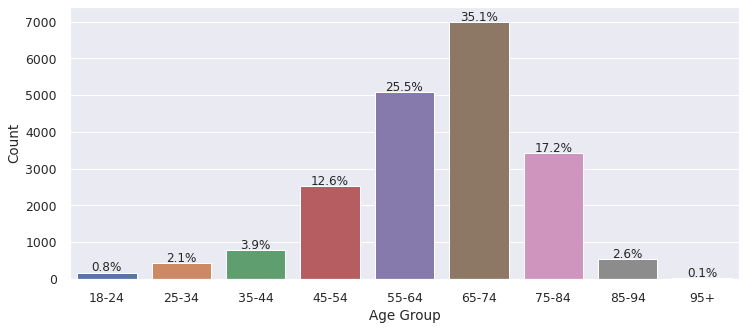

In [20]:
plt.figure(figsize = (12, 5));
cntplt = sns.countplot(data = df, x = 'Age Group', order = ['18-24', '25-34', '35-44', '45-54', 
                                                            '55-64', '65-74', '75-84', '85-94', '95+']);
countplot_labeling(cntplt, df);
plt.ylabel('Count');
plt.ylim(0, 7400);

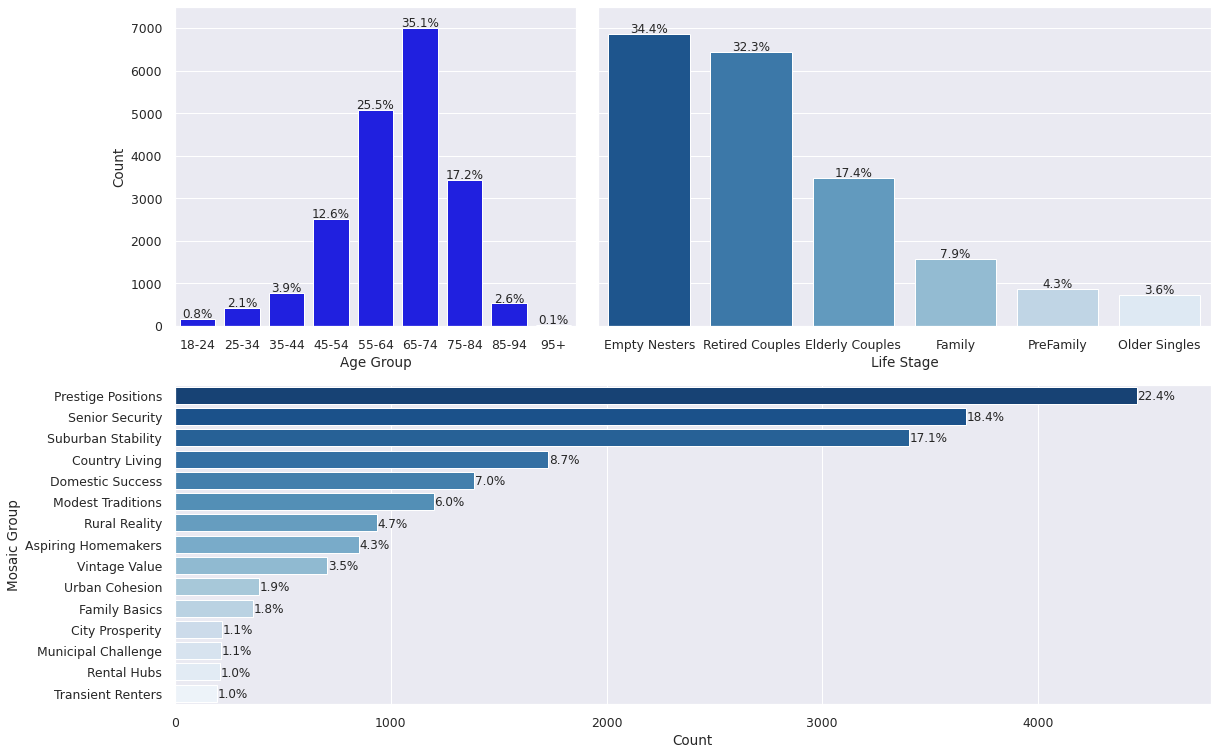

In [21]:
plt.figure(figsize = (16, 10));
plt.subplot(2,5,(1,2));
cntplt = sns.countplot(data = df, x = 'Age Group', order = ['18-24', '25-34', '35-44', '45-54', 
                                                            '55-64', '65-74', '75-84', '85-94', '95+'], color = 'blue');
countplot_labeling(cntplt, df);
plt.ylabel('Count');
plt.ylim(0, 7500);
plt.subplot(2,5,(3,5));
cntplt = sns.countplot(data = df, x = 'Lifestage', order = df['Lifestage'].value_counts(ascending = False).index, palette = 'Blues_r');
countplot_labeling(cntplt, df);
plt.xlabel('Life Stage');
cntplt.set_yticklabels([]);
plt.ylabel('');
plt.ylim(0, 7500);
plt.subplot(2,5,(6, 10));
cntplt = sns.countplot(data = df, y = 'Mosaic Group', 
                       order = df['Mosaic Group'].value_counts(ascending = False).index, palette = 'Blues_r');
countplot_labeling_horiz(cntplt, df);
plt.xlabel('Count');
plt.ylabel('Mosaic Group');
plt.xlim(0, 4800);
plt.tight_layout(w_pad = 1.5, rect = (0, 0, 1.07, 1.07));
plt.savefig("univariate1.jpeg",
            bbox_inches ="tight",
            pad_inches = 0.2,
            face_color = 'grey',
            edge_color = 'white',
            transparent = False,
            orientation ='landscape');

**`Month`**

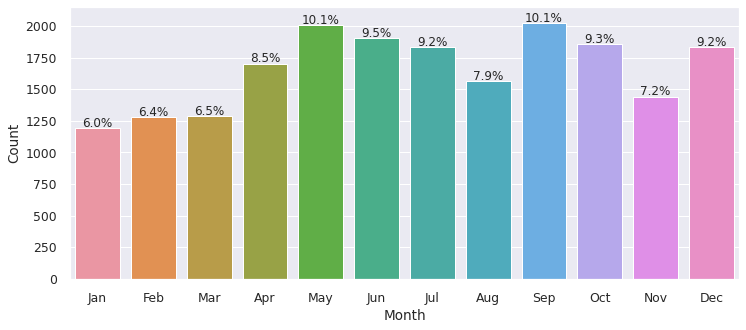

In [22]:
import calendar
plt.figure(figsize = (12, 5));
cntplt = sns.countplot(data = df, x = 'Month Name', order = calendar.month_abbr[1:13]);
countplot_labeling(cntplt, df);
plt.xlabel('Month');
plt.ylabel('Count');
plt.ylim(0, 2150);

**`Cruise Name`**

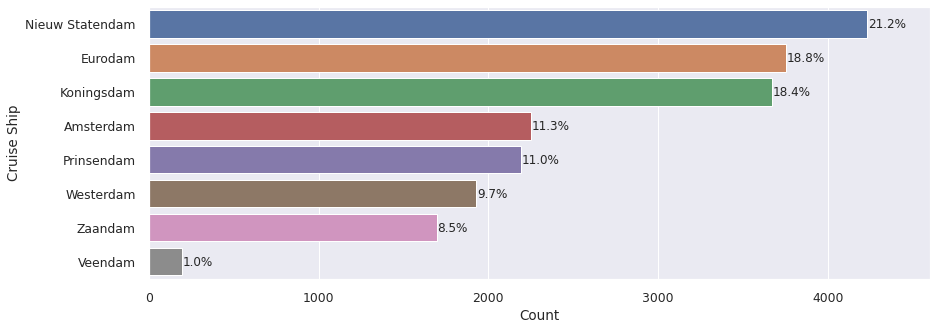

In [23]:
plt.figure(figsize = (14, 5));
cntplt = sns.countplot(data = df, y = 'Cruise Ship Name', 
                       order = df['Cruise Ship Name'].value_counts(ascending = False).index);
countplot_labeling_horiz(cntplt, df);
plt.xlabel('Count');
plt.ylabel('Cruise Ship');
plt.xlim(0, 4600);

**`Subtrade`**

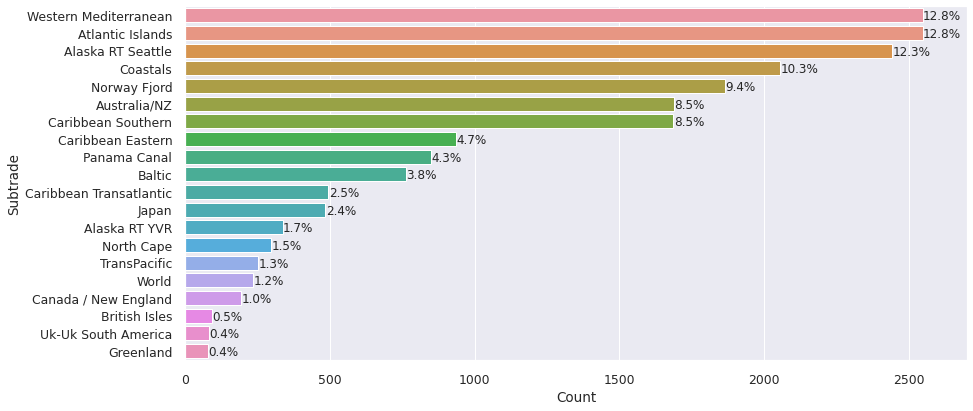

In [24]:
plt.figure(figsize = (14, 6.5));
cntplt = sns.countplot(data = df, y = 'Subtrade', 
                       order = df['Subtrade'].value_counts(ascending = False).index);
countplot_labeling_horiz(cntplt, df);
plt.xlabel('Count');
plt.ylabel('Subtrade');
plt.xlim(0, 2700);

**`Lifestage`**

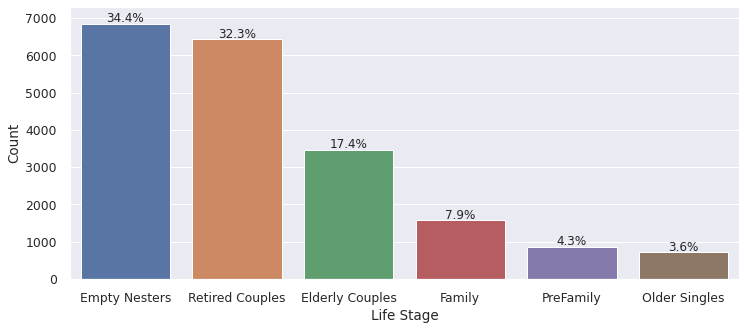

In [25]:
plt.figure(figsize = (12, 5));
cntplt = sns.countplot(data = df, x = 'Lifestage', order = df['Lifestage'].value_counts(ascending = False).index);
countplot_labeling(cntplt, df);
plt.xlabel('Life Stage');
plt.ylabel('Count');
plt.ylim(0, 7300);

**`Mosaic Group`**

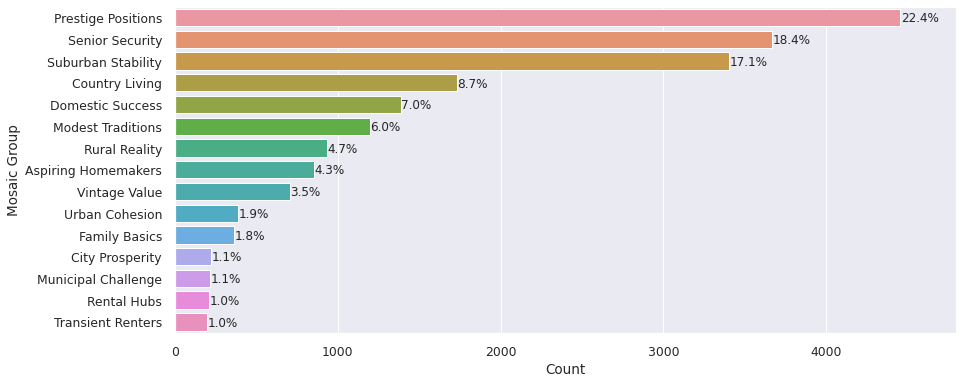

In [26]:
plt.figure(figsize = (14, 6));
cntplt = sns.countplot(data = df, y = 'Mosaic Group', 
                       order = df['Mosaic Group'].value_counts(ascending = False).index);
countplot_labeling_horiz(cntplt, df);
plt.xlabel('Count');
plt.ylabel('Mosaic Group');
plt.xlim(0, 4800);

**`Mosaic Type`**

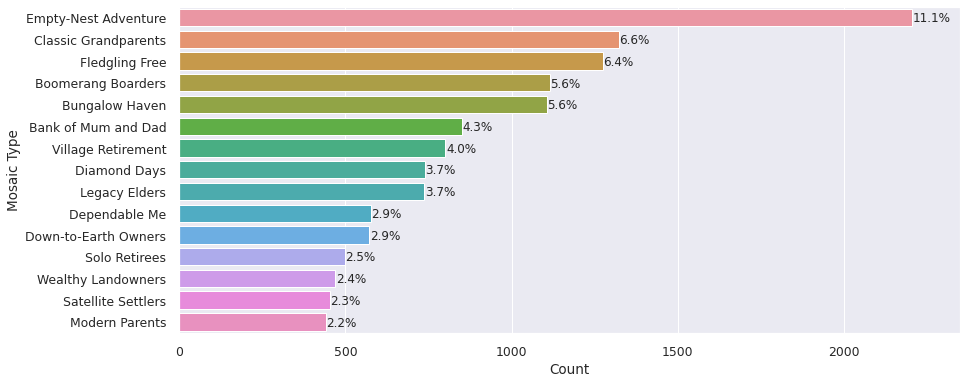

In [27]:
plt.figure(figsize = (14, 6));
cntplt = sns.countplot(data = df, y = 'Mosaic Type', 
                       order = df['Mosaic Type'].value_counts(ascending = False).index[:15]);
countplot_labeling_horiz(cntplt, df);
plt.xlabel('Count');
plt.ylabel('Mosaic Type');
plt.xlim(0, 2350);

**`Children`**

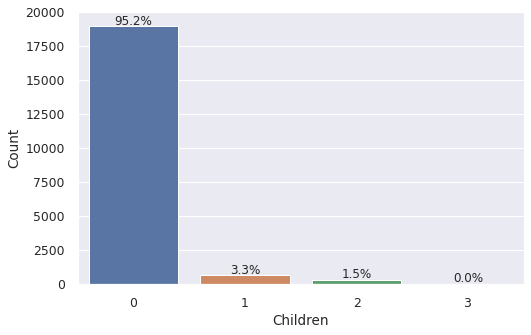

In [28]:
plt.figure(figsize = (8, 5));
cntplt = sns.countplot(data = df, x = 'Children', order = np.arange(0, df['Children'].max()+1));
countplot_labeling(cntplt, df);
plt.xlabel('Children');
plt.ylabel('Count');
plt.ylim(0, 20000);

**`Fare Type`**

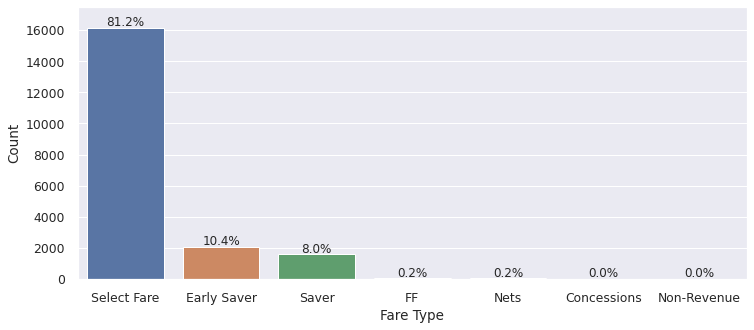

In [29]:
plt.figure(figsize = (12, 5));
cntplt = sns.countplot(data = df, x = 'Faretype', order = 
                       df['Faretype'].value_counts(ascending = False).index);
countplot_labeling(cntplt, df);
plt.xlabel('Fare Type');
plt.ylabel('Count');
plt.ylim(0, 17500);

**`Cabin`**

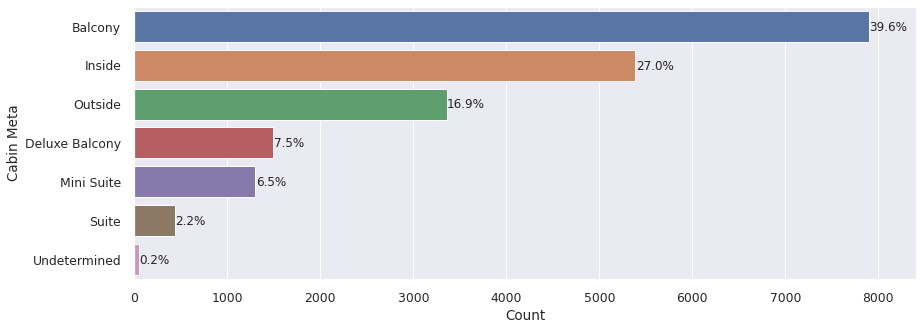

In [30]:
plt.figure(figsize = (14, 5));
cntplt = sns.countplot(data = df, y = 'Cabin', 
                       order = df['Cabin'].value_counts(ascending = False).index);
countplot_labeling_horiz(cntplt, df);
plt.xlabel('Count');
plt.ylabel('Cabin Meta');
plt.xlim(0, 8400);

**`Cruise Experience`**

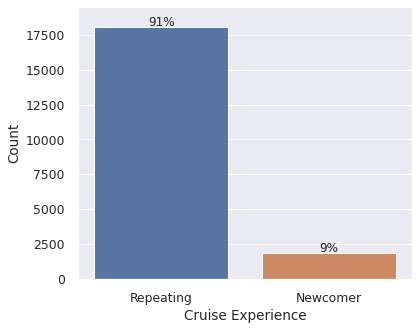

In [31]:
plt.figure(figsize = (6, 5));
cntplt = sns.countplot(data = df, x = 'Cruise Experience', order = 
                       df['Cruise Experience'].value_counts(ascending = False).index);
countplot_labeling(cntplt, df, perc = True, decimal = 0);
plt.xlabel('Cruise Experience');
plt.ylabel('Count');
plt.ylim(0, 19500);

**`Region`**

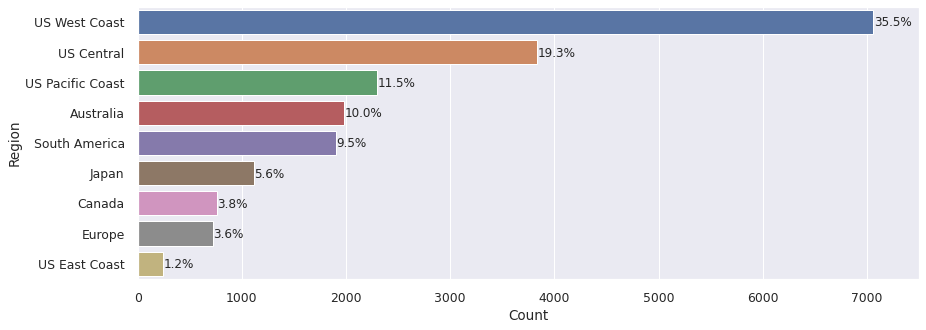

In [32]:
plt.figure(figsize = (14, 5));
cntplt = sns.countplot(data = df, y = 'Region', 
                       order = df['Region'].value_counts(ascending = False).index);
countplot_labeling_horiz(cntplt, df);
plt.xlabel('Count');
plt.ylabel('Region');
plt.xlim(0, 7500);

**`Contactability`**

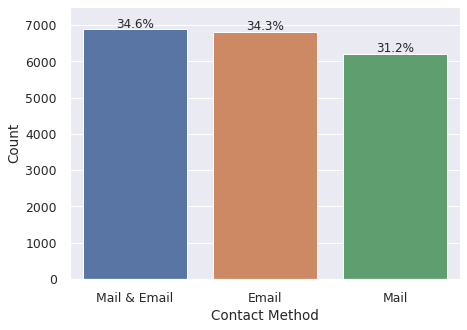

In [33]:
plt.figure(figsize = (7, 5));
cntplt = sns.countplot(data = df, x = 'Contactability', order = 
                       df['Contactability'].value_counts(ascending = False).index);
countplot_labeling(cntplt, df);
plt.xlabel('Contact Method');
plt.ylabel('Count');
plt.ylim(0, 7500);

**`Lead Time`**

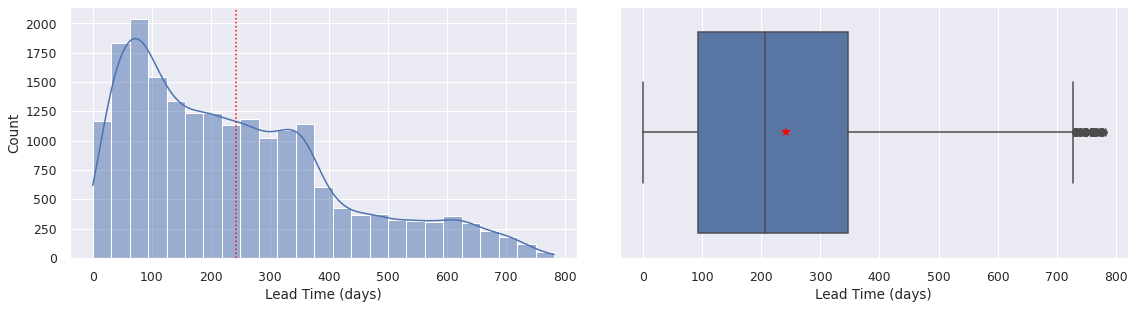

In [34]:
plt.figure(figsize = (16, 4.5));
plt.subplot(121);
sns.histplot(data = df, x = 'Lead Time', kde = True, bins = 25);
plt.axvline(df['Lead Time'].mean(), color = 'red', linestyle = ':');
plt.xlabel('Lead Time (days)');
plt.subplot(122);
sns.boxplot(data = df, x = 'Lead Time', showmeans = True, meanprops = 
             {'marker': '*', 'markerfacecolor': 'red', 'markeredgecolor': 'red', 'markersize': '10'});
plt.xlabel('Lead Time (days)');
plt.tight_layout(w_pad = 3);

**`Weekly Income`**

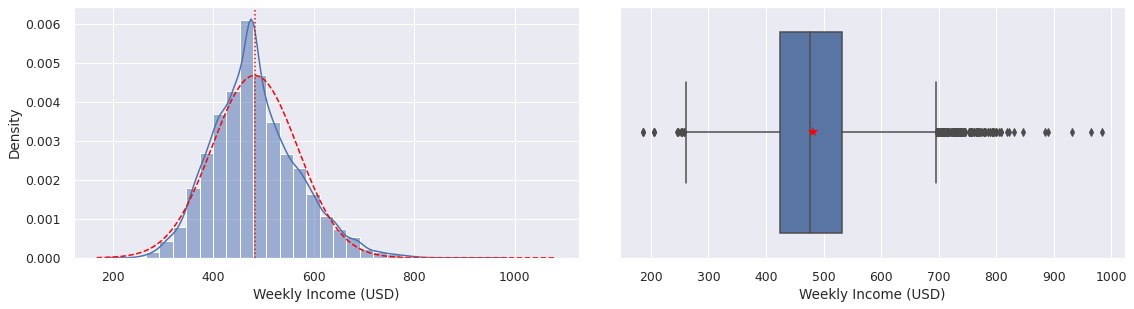

In [35]:
# Equaivalent normal distribution of income
x_income_dist = np.linspace(0.9*df['Weekly Income'].min(), 1.1*df['Weekly Income'].max(), 100)
income_norm_dist = norm.pdf(x_income_dist, loc = df['Weekly Income'].mean(), scale = df['Weekly Income'].std(ddof = 1))

plt.figure(figsize = (16, 4.5));
plt.subplot(121);
sns.histplot(data = df, x = 'Weekly Income', stat = 'density', kde = True, bins = 30);
plt.axvline(df['Weekly Income'].mean(), color = 'red', linestyle = ':');
plt.plot(x_income_dist, income_norm_dist, color = 'red', linestyle = '--');
plt.xlabel('Weekly Income (USD)');
plt.subplot(122);
sns.boxplot(data = df, x = 'Weekly Income', showmeans = True, meanprops = 
             {'marker': '*', 'markerfacecolor': 'red', 'markeredgecolor': 'red', 'markersize': '10'});
plt.xlabel('Weekly Income (USD)');
plt.tight_layout(w_pad = 3);

**`No. of Previous Cruises`**

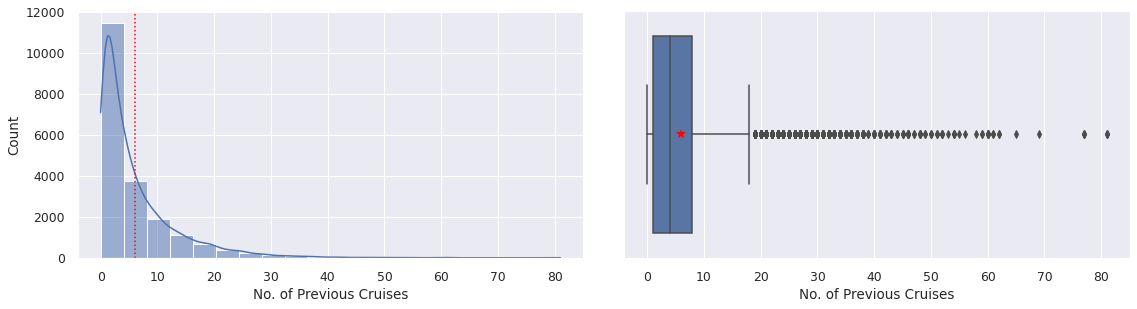

In [36]:
plt.figure(figsize = (16, 4.5));
plt.subplot(121);
sns.histplot(data = df, x = 'No. of Previous Cruises', kde = True, bins = 20);
plt.axvline(df['No. of Previous Cruises'].mean(), color = 'red', linestyle = ':');
plt.xlabel('No. of Previous Cruises');
plt.subplot(122);
sns.boxplot(data = df, x = 'No. of Previous Cruises', showmeans = True, meanprops = 
             {'marker': '*', 'markerfacecolor': 'red', 'markeredgecolor': 'red', 'markersize': '10'});
plt.xlabel('No. of Previous Cruises');
plt.tight_layout(w_pad = 3);

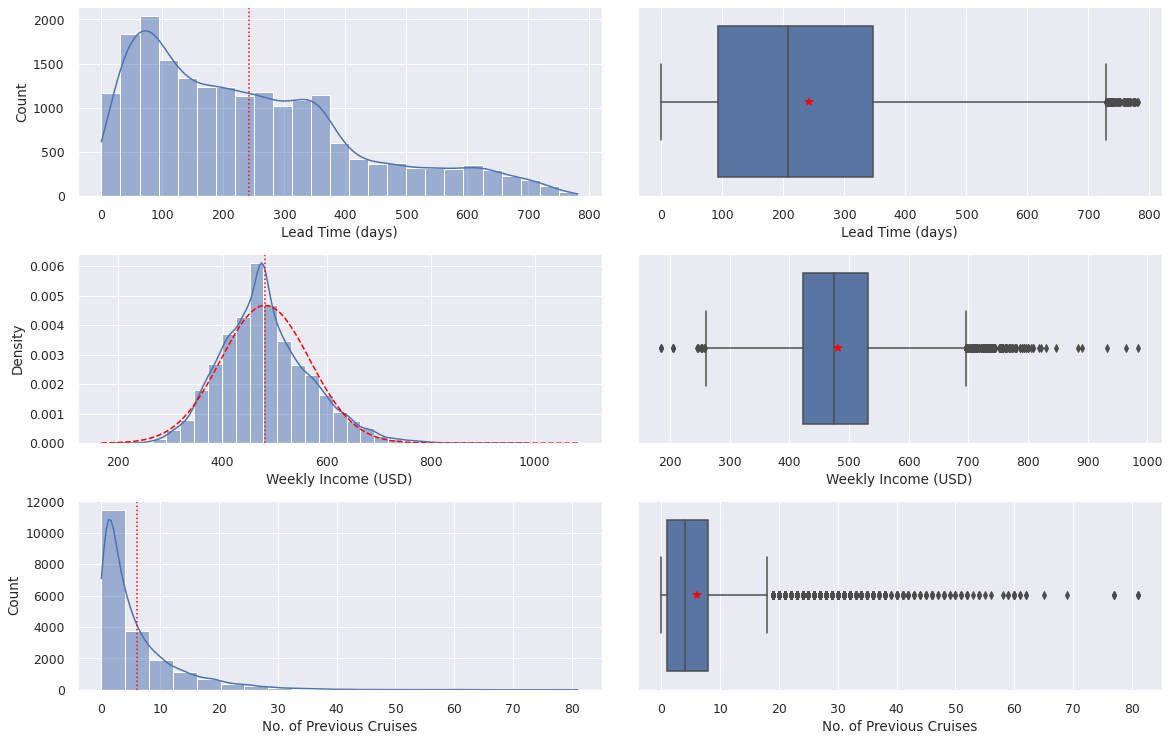

In [37]:
plt.figure(figsize = (16.5, 10.5));
plt.subplot(321);
sns.histplot(data = df, x = 'Lead Time', kde = True, bins = 25);
plt.axvline(df['Lead Time'].mean(), color = 'red', linestyle = ':');
plt.xlabel('Lead Time (days)');
plt.subplot(322);
sns.boxplot(data = df, x = 'Lead Time', showmeans = True, meanprops = 
             {'marker': '*', 'markerfacecolor': 'red', 'markeredgecolor': 'red', 'markersize': '10'});
plt.xlabel('Lead Time (days)');
plt.subplot(323);
x_income_dist = np.linspace(0.9*df['Weekly Income'].min(), 1.1*df['Weekly Income'].max(), 100)
income_norm_dist = norm.pdf(x_income_dist, loc = df['Weekly Income'].mean(), scale = df['Weekly Income'].std(ddof = 1))
sns.histplot(data = df, x = 'Weekly Income', stat = 'density', kde = True, bins = 30);
plt.axvline(df['Weekly Income'].mean(), color = 'red', linestyle = ':');
plt.plot(x_income_dist, income_norm_dist, color = 'red', linestyle = '--');
plt.xlabel('Weekly Income (USD)');
plt.subplot(324);
sns.boxplot(data = df, x = 'Weekly Income', showmeans = True, meanprops = 
             {'marker': '*', 'markerfacecolor': 'red', 'markeredgecolor': 'red', 'markersize': '10'});
plt.xlabel('Weekly Income (USD)');
plt.subplot(325);
sns.histplot(data = df, x = 'No. of Previous Cruises', kde = True, bins = 20);
plt.axvline(df['No. of Previous Cruises'].mean(), color = 'red', linestyle = ':');
plt.xlabel('No. of Previous Cruises');
plt.subplot(326);
sns.boxplot(data = df, x = 'No. of Previous Cruises', showmeans = True, meanprops = 
             {'marker': '*', 'markerfacecolor': 'red', 'markeredgecolor': 'red', 'markersize': '10'});
plt.xlabel('No. of Previous Cruises');
plt.tight_layout(w_pad = 2.5, h_pad = 1);
plt.savefig("univariate3.jpeg",
            bbox_inches ="tight",
            pad_inches = 0.2,
            face_color = 'grey',
            edge_color = 'white',
            transparent = False,
            orientation ='landscape');

**`Duration`**

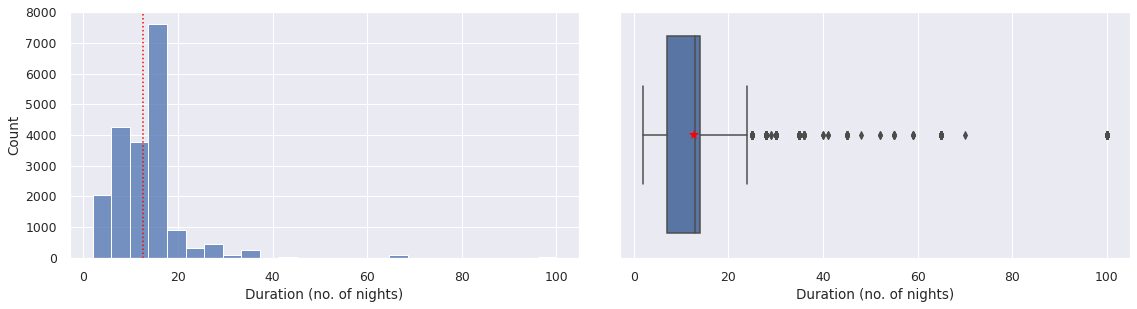

In [38]:
plt.figure(figsize = (16, 4.5));
plt.subplot(121);
sns.histplot(data = df, x = 'Duration', bins = 25);
plt.axvline(df['Duration'].mean(), color = 'red', linestyle = ':');
plt.xlabel('Duration (no. of nights)');
plt.subplot(122);
sns.boxplot(data = df, x = 'Duration', showmeans = True, meanprops = 
             {'marker': '*', 'markerfacecolor': 'red', 'markeredgecolor': 'red', 'markersize': '10'});
plt.xlabel('Duration (no. of nights)');
plt.tight_layout(w_pad = 3);

**`Age (Numerical)`**

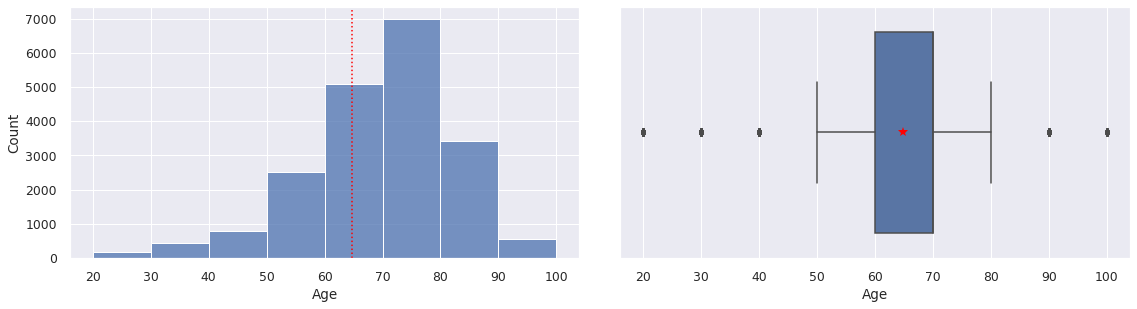

In [39]:
plt.figure(figsize = (16, 4.5));
plt.subplot(121);
sns.histplot(data = df, x = 'Num. Age', binwidth = 10);
plt.axvline(df['Num. Age'].mean(), color = 'red', linestyle = ':');
plt.xlabel('Age');
plt.subplot(122);
sns.boxplot(data = df, x = 'Num. Age', showmeans = True, meanprops = 
             {'marker': '*', 'markerfacecolor': 'red', 'markeredgecolor': 'red', 'markersize': '10'});
plt.xlabel('Age');
plt.tight_layout(w_pad = 3);

### Bivariate Analysis

**`Correlation Heatmap of Numerical Variables`**

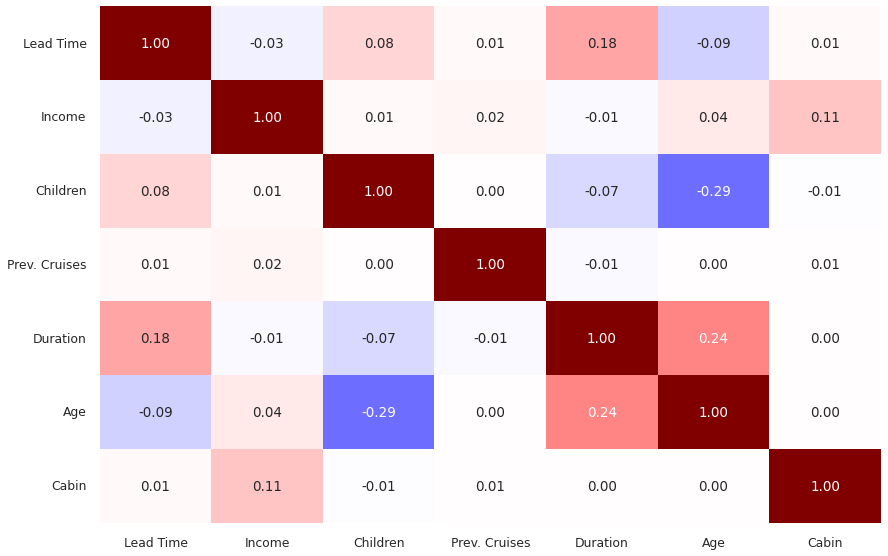

In [41]:
plt.figure(figsize = (14, 9.5));
num_vars = df.select_dtypes(include = np.number).columns.tolist()
num_vars.remove('Month')

corrmap = sns.heatmap(data = df[num_vars].corr(), annot = True, fmt = '.2f', cmap = 'seismic',
                      cbar = False, vmin = -1, vmax = 1);
corrmap.set_xticklabels(['Lead Time', 'Income', 'Children', 'Prev. Cruises', 'Duration', 'Age', 'Cabin']);
corrmap.set_yticklabels(['Lead Time', 'Income', 'Children', 'Prev. Cruises', 'Duration', 'Age', 'Cabin']);
plt.savefig("correlation_heatmap.jpeg",
            bbox_inches ="tight",
            pad_inches = 0.1,
            face_color = 'grey',
            edge_color = 'white',
            transparent = False,
            orientation ='landscape');


**`Pairplot of Numerical Variables w.r.t. Method of Contact`**

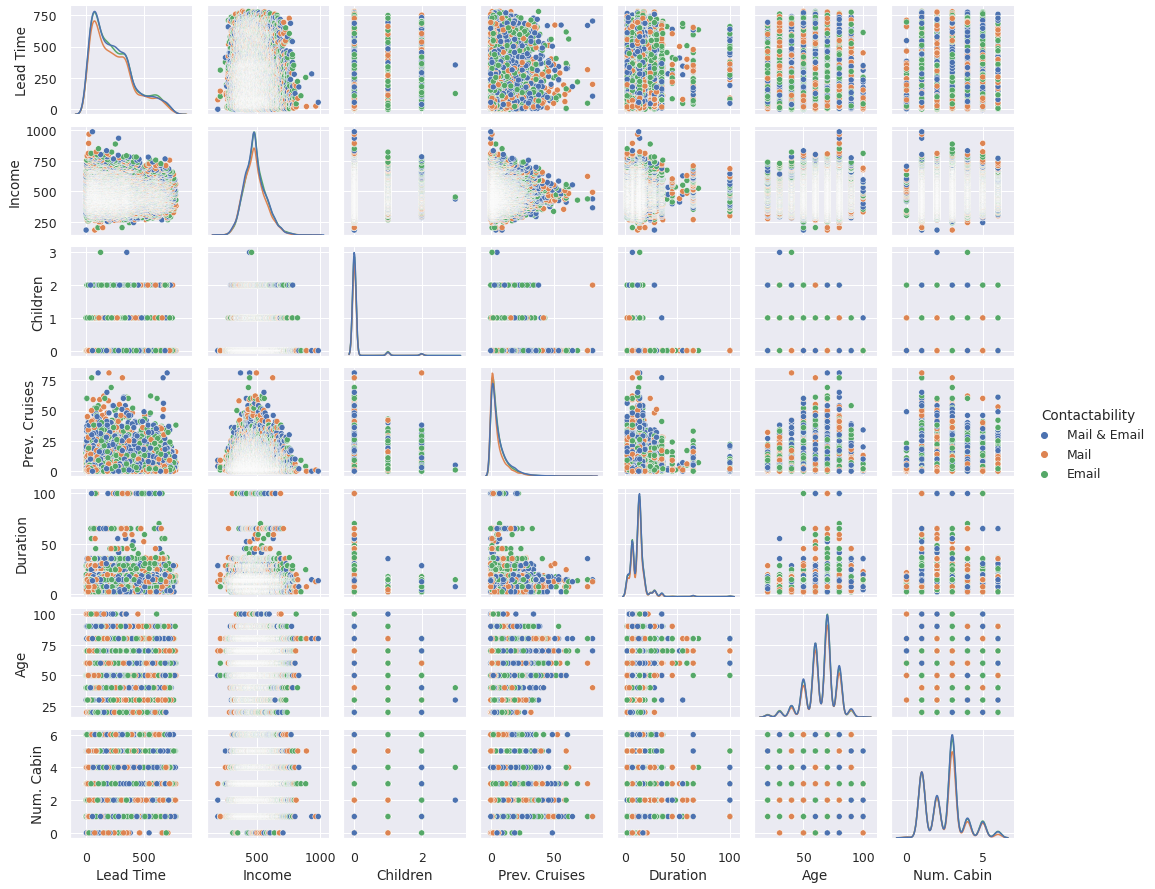

In [42]:
df_num = df[num_vars + ['Contactability']].copy()
df_num.rename(columns = {'Weekly Income': 'Income', 'No. of Previous Cruises': 'Prev. Cruises',
                         'Num. Age': 'Age'}, inplace = True)
sns.pairplot(df_num, hue = 'Contactability', diag_kind = 'kde', diag_kws = dict(fill = False), 
             height = 1.8, aspect = 1.15); 

**`Lifestage and Age Group vs. Weekly Income`**

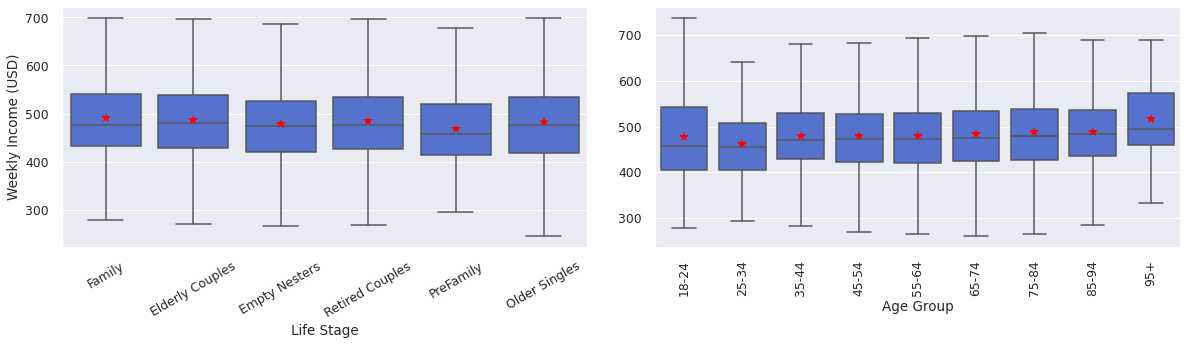

In [43]:
plt.figure(figsize = (16.7, 5));
plt.subplot(121);
sns.boxplot(data = df, x = 'Lifestage', y = 'Weekly Income', showmeans = True, showfliers = False,
            meanprops = {'marker': '*', 'markerfacecolor': 'red', 'markeredgecolor': 'red', 'markersize': '10'}, color = 'royalblue');
plt.xticks(rotation = 30);
plt.xlabel('Life Stage');
plt.ylabel('Weekly Income (USD)');
plt.subplot(122);
sns.boxplot(data = df, x = 'Age Group', y = 'Weekly Income', showfliers = False, showmeans = True, 
            order = ['18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75-84', '85-94', '95+'],  
            meanprops = {'marker': '*', 'markerfacecolor': 'red', 'markeredgecolor': 'red', 'markersize': '10'}, color = 'royalblue');
plt.xticks(rotation = 90);
plt.ylabel('');
plt.tight_layout(w_pad = 2);
plt.savefig("bivariate1.jpeg",
            bbox_inches ="tight",
            pad_inches = 0.1,
            face_color = 'grey',
            edge_color = 'white',
            transparent = False,
            orientation ='landscape');

**`Cruise Experience vs. Method of Contact`**

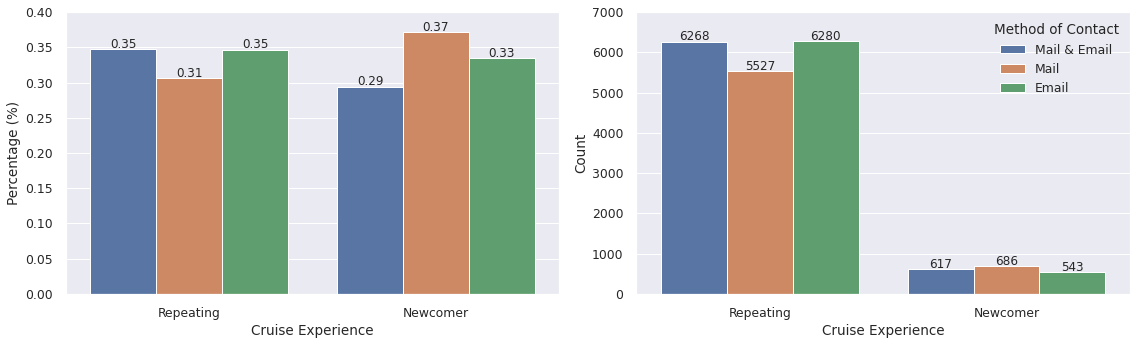

In [44]:
ctab = pd.crosstab(df['Cruise Experience'], df['Contactability'], normalize = 'index');
ctab = ctab.stack().reset_index()
ctab.rename(columns = {0: 'Values'}, inplace = True)

plt.figure(figsize = (16, 5));
# Plotting crosstab in percentage form
plt.subplot(121);
barplt = sns.barplot(data = ctab, x = 'Cruise Experience', y = 'Values', hue = 'Contactability',
                     order = ['Repeating', 'Newcomer']);
countplot_labeling(barplt, ctab, perc = False, decimal = 2);
plt.legend(title = 'Method of Contact').set_visible(False);
plt.xlabel('Cruise Experience');
plt.ylabel('Percentage (%)');
plt.ylim(0, 0.4);
# Plotting crosstab in count form
plt.subplot(122);
cntplt = sns.countplot(data = df, x = 'Cruise Experience', hue = 'Contactability')
                       #order = ['High School', 'Bachelor\'s', 'Master\'s', 'Doctorate']);
countplot_labeling(cntplt, df, perc = False);
plt.legend(title = 'Method of Contact');
plt.xlabel('Cruise Experience');
plt.ylabel('Count');
plt.ylim(0, 7000);
plt.tight_layout();

**`Cruise Experience vs. Duration of Cruise`**

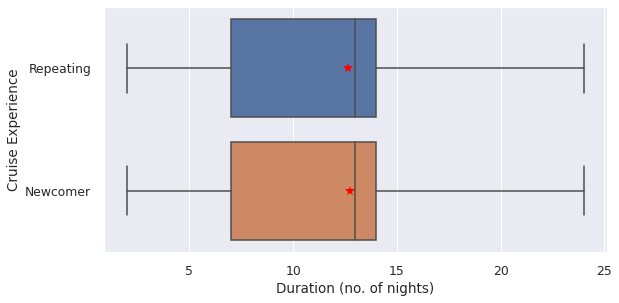

In [45]:
plt.figure(figsize = (9, 4.5));
sns.boxplot(data = df, x = 'Duration', y = 'Cruise Experience', showmeans = True, showfliers = False,
            meanprops = {'marker': '*', 'markerfacecolor': 'red', 'markeredgecolor': 'red', 'markersize': '10'});
plt.xlabel('Duration (no. of nights)');

**`Fare Type and Cabin Type vs. Weekly Income`**

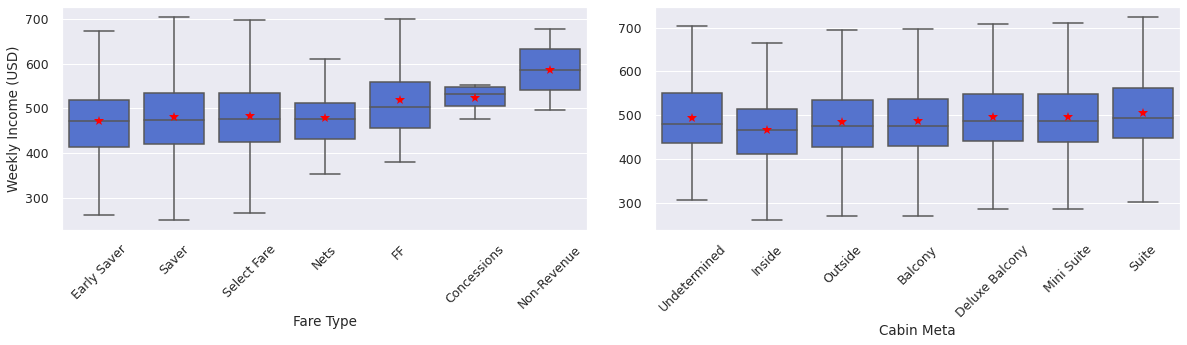

In [46]:
plt.figure(figsize = (16.7, 5));
plt.subplot(121);
sns.boxplot(data = df, x = 'Faretype', y = 'Weekly Income', showfliers = False, showmeans = True,
            meanprops = {'marker': '*', 'markerfacecolor': 'red', 'markeredgecolor': 'red', 'markersize': '10'},
            order = df.groupby('Faretype')['Weekly Income'].median().sort_values().index, color = 'royalblue');
plt.xticks(rotation = 45);
plt.xlabel('Fare Type');
plt.ylabel('Weekly Income (USD)');
plt.subplot(122);
sns.boxplot(data = df, x = 'Cabin', y = 'Weekly Income', showfliers = False, showmeans = True,  
            order = ['Undetermined', 'Inside', 'Outside', 'Balcony', 'Deluxe Balcony', 'Mini Suite', 'Suite'],
            meanprops = {'marker': '*', 'markerfacecolor': 'red', 'markeredgecolor': 'red', 'markersize': '10'},
            color = 'royalblue');
plt.xticks(rotation = 45);
plt.xlabel('Cabin Meta');
plt.ylabel('');
plt.tight_layout(w_pad = 2);
plt.savefig("bivariate2.jpeg",
            bbox_inches ="tight",
            pad_inches = 0.1,
            face_color = 'grey',
            edge_color = 'white',
            transparent = False,
            orientation ='landscape');

**`Moasic Group vs. Duration of Cruise and Weekly Income`**

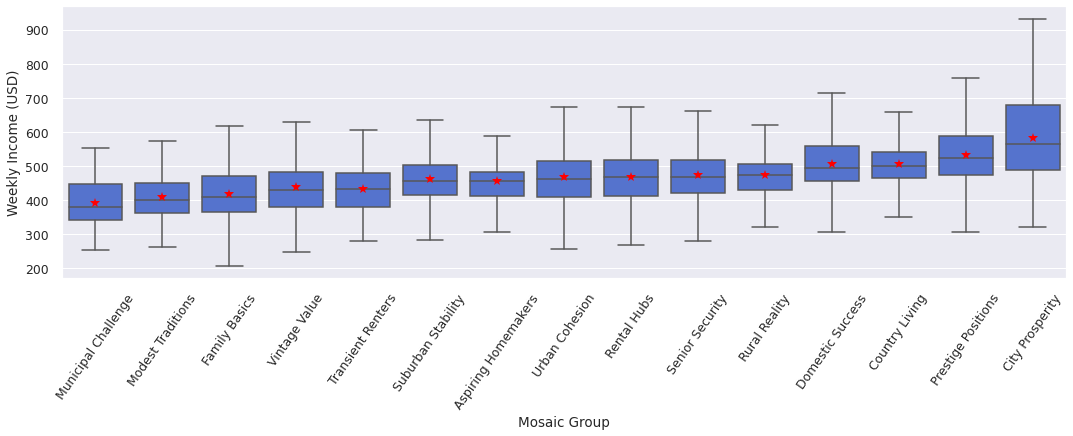

In [47]:
plt.figure(figsize = (18, 5));
sns.boxplot(data = df, x = 'Mosaic Group', y = 'Weekly Income', showfliers = False, showmeans = True,
            meanprops = {'marker': '*', 'markerfacecolor': 'red', 'markeredgecolor': 'red', 'markersize': '10'},
            order = df.groupby('Mosaic Group')['Weekly Income'].median().sort_values().index, 
            color = 'royalblue');
plt.ylabel('Weekly Income (USD)');
plt.xticks(rotation = 55);
plt.savefig("bivariate3.jpeg",
            bbox_inches ="tight",
            pad_inches = 0.1,
            face_color = 'grey',
            edge_color = 'white',
            transparent = False,
            orientation ='landscape');

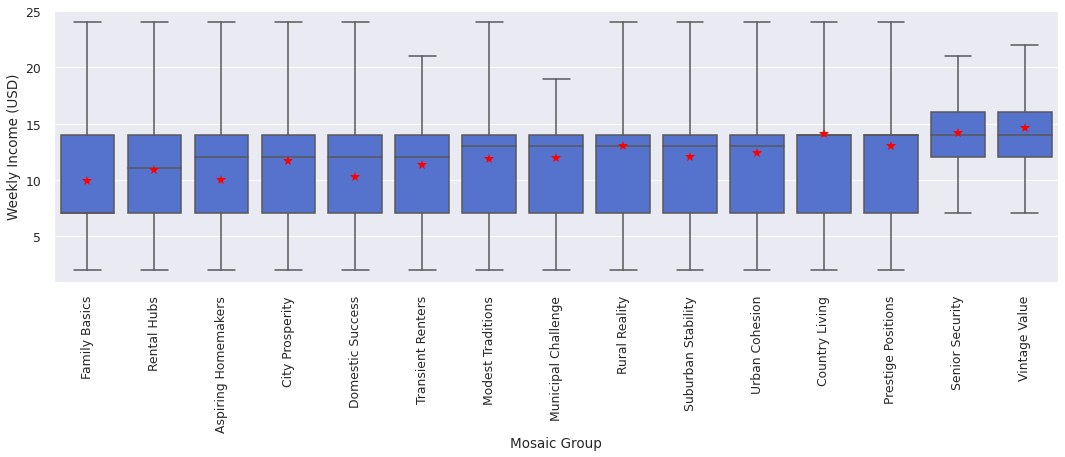

In [48]:
plt.figure(figsize = (18, 5));
sns.boxplot(data = df, x = 'Mosaic Group', y = 'Duration', showfliers = False, showmeans = True,
            meanprops = {'marker': '*', 'markerfacecolor': 'red', 'markeredgecolor': 'red', 'markersize': '10'},
            order = df.groupby('Mosaic Group')['Duration'].median().sort_values().index, color = 'royalblue');
plt.ylabel('Weekly Income (USD)');
plt.xticks(rotation = 90);

## K-Prototypes Clustering

### Building the Model

In [49]:
# Choosing the features being used for cluster-based modeling
clustering_features = ['Num. Age', 'Weekly Income', 'Children', 'Mosaic Group', 'Mosaic Type', 'Region',
                       'No. of Previous Cruises', 'Duration', 'Lead Time', 'Lifestage']
df_model = df[clustering_features]
df_model.rename(columns = {'Num. Age': 'Age', 'Num. Cabin': 'Cabin'}, inplace = True)
df_model.head()

,Age,Weekly Income,Children,Mosaic Group,Mosaic Type,Region,No. of Previous Cruises,Duration,Lead Time,Lifestage
0,50,473.95,0,Aspiring Homemakers,New Foundations,Canada,1,12,12,Family
1,80,480.20,0,Vintage Value,Aided Elderly,US Central,6,14,154,Elderly Couples
2,60,473.90,0,Country Living,Village Retirement,Canada,13,13,222,Empty Nesters
3,70,475.80,0,Prestige Positions,Bank of Mum and Dad,US Pacific Coast,7,14,624,Retired Couples
4,60,473.90,0,Prestige Positions,Alpha Families,Canada,0,10,62,Empty Nesters


In [50]:
# Scaling the numerical features
scaler = StandardScaler()
num_cols = df_model.select_dtypes(include = np.number).columns.tolist()
df_scaled = df_model.copy()
df_scaled[num_cols] = scaler.fit_transform(df_model[num_cols])
df_scaled.head()

,Age,Weekly Income,Children,Mosaic Group,Mosaic Type,Region,No. of Previous Cruises,Duration,Lead Time,Lifestage
0,-1.14,-0.10,-0.21,Aspiring Homemakers,New Foundations,Canada,-0.70,-0.08,-1.29,Family
1,1.18,-0.02,-0.21,Vintage Value,Aided Elderly,US Central,-0.01,0.17,-0.50,Elderly Couples
2,-0.37,-0.10,-0.21,Country Living,Village Retirement,Canada,0.96,0.04,-0.11,Empty Nesters
3,0.40,-0.07,-0.21,Prestige Positions,Bank of Mum and Dad,US Pacific Coast,0.13,0.17,2.15,Retired Couples
4,-0.37,-0.10,-0.21,Prestige Positions,Alpha Families,Canada,-0.84,-0.33,-1.01,Empty Nesters


In [51]:
# Finding the indices of categorical columns
cat_cols = df_model.select_dtypes(include = ['category', 'object']).columns.tolist()
cat_cols_indices = [] 
for col in cat_cols:
    cat_cols_indices.append(df_model.columns.get_loc(col))
cat_cols_indices

[3, 4, 5, 9]

In [52]:
# Calculating the cost function for the entire range of no. of clusters
from tqdm import tqdm
k_range = np.arange(1, 13)
cost = []
for k in tqdm(k_range):
    kproto_model = KPrototypes(n_clusters = k, init = 'Cao', max_iter = 200, n_init = 1, random_state = 1, n_jobs = -1)
    kproto_model.fit_predict(df_scaled, categorical = cat_cols_indices)
    cost.append(kproto_model.cost_)

100%|██████████| 12/12 [16:41<00:00, 83.50s/it] 


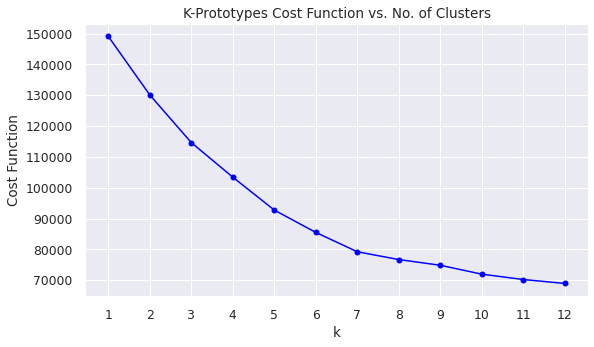

In [53]:
# Plotting cost vs. k
plt.figure(figsize = (9, 5));
plt.plot(k_range, cost, color = 'blue', marker = 'o');
plt.xlabel('k');
plt.ylabel('Cost Function');
plt.xticks(ticks = k_range);
plt.title('K-Prototypes Cost Function vs. No. of Clusters');
plt.savefig("k-prototypes_elbow_plot.jpeg",
            bbox_inches ="tight",
            pad_inches = 0.2,
            face_color = 'grey',
            edge_color = 'white',
            transparent = False,
            orientation ='landscape');

In [54]:
# Building the final model with the select k
best_k = 5
final_proto_model = KPrototypes(n_clusters = best_k, init = 'Cao', max_iter = 100, n_init = 5,
                                verbose = 1, random_state = 1)
final_proto_model.fit_predict(df_scaled, categorical = cat_cols_indices)
df_model['K-Proto Segment'] = final_proto_model.labels_
df['K-Proto Segment'] = final_proto_model.labels_

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 5277, ncost: 99606.56825632206
Run: 1, iteration: 2/100, moves: 2552, ncost: 98200.58685507058
Run: 1, iteration: 3/100, moves: 1395, ncost: 97796.05563966562
Run: 1, iteration: 4/100, moves: 935, ncost: 97539.9109259743
Run: 1, iteration: 5/100, moves: 838, ncost: 97325.6597888159
Run: 1, iteration: 6/100, moves: 734, ncost: 97164.28030942919
Run: 1, iteration: 7/100, moves: 1747, ncost: 95977.88055271561
Run: 1, iteration: 8/100, moves: 1884, ncost: 95127.54401002059
Run: 1, iteration: 9/100, moves: 1576, ncost: 94393.36950416978
Run: 1, iteration: 10/100, moves: 1363, ncost: 93854.22358859083
Run: 1, iteration: 11/100, moves: 934, ncost: 93119.32541026801
Run: 1, iteration: 12/100, moves: 660, ncost: 92809.39979403761
Run: 1, iteration: 13/100, moves: 324, ncost: 92753.25576399542
Run: 1, iteratio

**`Cluster Profiling`**




In [55]:
# Categorical centroids
final_proto_model.cluster_centroids_[:, -len(cat_cols):]

array([['Prestige Positions', 'Empty-Nest Adventure', 'US West Coast',
        'Retired Couples'],
       ['Domestic Success', 'Mid-Career Convention', 'US West Coast',
        'Family'],
       ['Suburban Stability', 'Fledgling Free', 'US West Coast',
        'Empty Nesters'],
       ['Prestige Positions', 'Empty-Nest Adventure', 'US West Coast',
        'Retired Couples'],
       ['Senior Security', 'Classic Grandparents', 'US West Coast',
        'Retired Couples']], dtype='<U32')

In [56]:
# Separating the data points of each cluster and indicating each cluster by its centroid
num_clust_profile = df_model.groupby('K-Proto Segment')[num_cols].mean()
# Adding the number of data points in each cluster to the cluster profiling
num_clust_profile['Count'] = df_model['K-Proto Segment'].value_counts()[np.sort(df_model
                                                                               ['K-Proto Segment'].value_counts().index)]/df.shape[0]*100
num_clust_profile.style.highlight_max(color = 'lightgreen', axis = 0)

,Age,Weekly Income,Children,No. of Previous Cruises,Duration,Lead Time,Count
K-Proto Segment,,,,,,,
0,66.757311,492.939302,0.003079,22.569010,12.219087,226.548999,9.783645
1,47.636555,486.124580,1.324580,5.968487,9.846639,304.651261,4.778877
2,53.467224,476.606178,0.000000,4.255302,9.414524,200.555431,31.243411
3,67.889462,488.077420,0.000286,4.481100,19.244845,494.321019,17.529240
4,74.612541,480.739526,0.000274,3.963719,12.758078,153.120345,36.664826


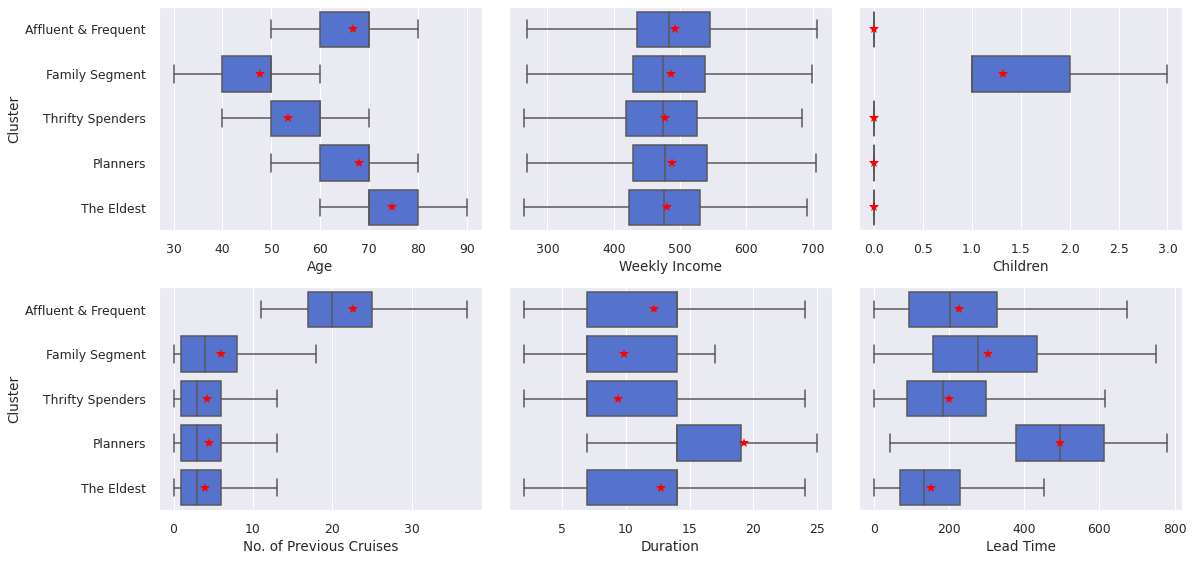

In [57]:
# Boxplot distribution of numerical variables for each cluster
plt.figure(figsize = (16.8, 8));
#plt.suptitle('Distribution of Numerical Attributes w.r.t. Cluster');
for i, col in enumerate(num_cols):
    plt.subplot(2, 3, i+1);
    bxplt = sns.boxplot(data = df_model, x = col, y = 'K-Proto Segment', showmeans = True, showfliers = False, orient = 'h', 
                        meanprops = {'marker': '*', 'markerfacecolor': 'red', 'markeredgecolor': 'red', 'markersize': '10'}, 
                        order = np.arange(0, best_k), color = 'royalblue');
    if(i%3 == 0):
      plt.ylabel('Cluster');
      bxplt.set_yticklabels(['Affluent & Frequent', 'Family Segment', 'Thrifty Spenders', 'Planners', 'The Eldest']);
    else:
      plt.ylabel('');
      bxplt.set_yticklabels([]);
plt.tight_layout(h_pad = 1, w_pad = 2);
plt.savefig("clusters_num_dist.jpeg",
            bbox_inches ="tight",
            pad_inches = 0.1,
            face_color = 'grey',
            edge_color = 'white',
            transparent = False,
            orientation ='landscape');

**`Distribution of Cruise Ships Among Clusters`**

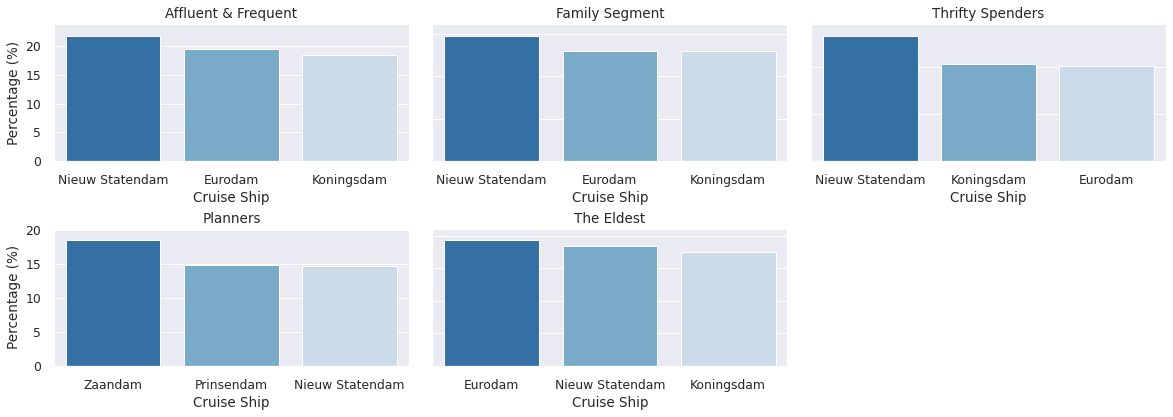

In [58]:
clusters_dict = {0: 'Affluent & Frequent', 1:'Family Segment', 2:'Thrifty Spenders', 
                 3:'Planners', 4:'The Eldest'}
plt.figure(figsize = (16.5, 6));
for k in range(0, best_k): 
    plt.subplot(2, 3, k+1);
    df_temp = df.loc[df['K-Proto Segment'] == k]
    df_temp.reset_index(inplace = True, drop = True)
    barplt = sns.barplot(x = df_temp['Cruise Ship Name'].value_counts(ascending = False).index[0:3],
                         y = df_temp['Cruise Ship Name'].value_counts(normalize = True, ascending = False)[0:3]*100,
                         palette = 'Blues_r');
    plt.ylim(0, plt.gca().get_ylim()[1]*1.04)
    plt.title(clusters_dict[k]);
    plt.xlabel('Cruise Ship');
    if(k%3 == 0):
      plt.ylabel('Percentage (%)');
    else:
      plt.ylabel('');
      barplt.set_yticklabels([]);
plt.tight_layout(w_pad = 1, h_pad = 0.5);
plt.savefig("cluster_results_ships.jpeg",
            bbox_inches ="tight",
            pad_inches = 0.1,
            face_color = 'grey',
            edge_color = 'white',
            transparent = False,
            orientation ='landscape');

**`Distribution of Subtrades Among Clusters`**

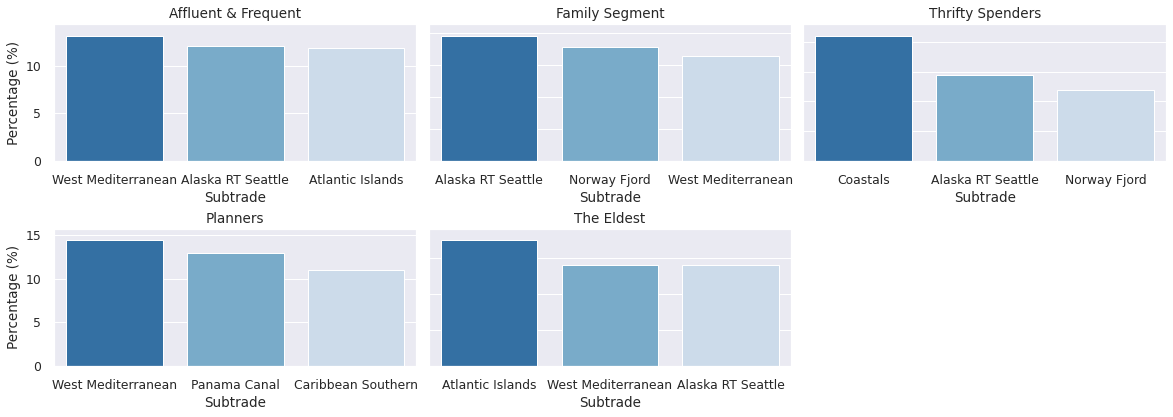

In [59]:
plt.figure(figsize = (16.5, 6));
for k in range(0, best_k): 
    plt.subplot(2, 3, k+1);
    df_temp = df.loc[df['K-Proto Segment'] == k]
    df_temp.reset_index(inplace = True, drop = True)
    df_temp['Subtrade'].replace('Western Mediterranean', 'West Mediterranean', inplace = True);
    barplt = sns.barplot(x = df_temp['Subtrade'].value_counts(ascending = False).index[0:3],
                         y = df_temp['Subtrade'].value_counts(normalize = True, ascending = False)[0:3]*100,
                         palette = 'Blues_r');
    plt.ylim(0, plt.gca().get_ylim()[1]*1.04)
    plt.title(clusters_dict[k]);
    plt.xlabel('Subtrade');
    if(k%3 == 0):
      plt.ylabel('Percentage (%)');
    else:
      plt.ylabel('');
      barplt.set_yticklabels([]);
plt.tight_layout(w_pad = -0.5, h_pad = 0.5);
plt.savefig("cluster_results_subtrades.jpeg",
            bbox_inches ="tight",
            pad_inches = 0.1,
            face_color = 'grey',
            edge_color = 'white',
            transparent = False,
            orientation ='landscape');

**`Distribution of Lifestages Among Clusters`**

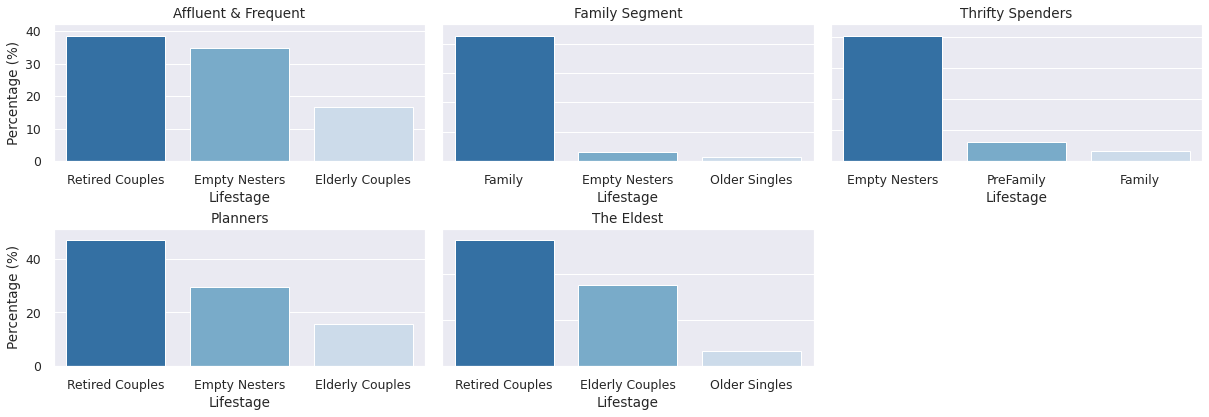

In [60]:
plt.figure(figsize = (17, 6));
for k in range(0, best_k): 
    plt.subplot(2, 3, k+1);
    df_temp = df.loc[df['K-Proto Segment'] == k]
    df_temp.reset_index(inplace = True, drop = True)
    barplt = sns.barplot(x = df_temp['Lifestage'].value_counts(ascending = False).index[0:3],
                         y = df_temp['Lifestage'].value_counts(normalize = True, ascending = False)[0:3]*100,
                         palette = 'Blues_r');
    plt.ylim(0, plt.gca().get_ylim()[1]*1.04)
    plt.title(clusters_dict[k]);
    plt.xlabel('Lifestage');
    if(k%3 == 0):
      plt.ylabel('Percentage (%)');
    else:
      plt.ylabel('');
      barplt.set_yticklabels([]);
plt.tight_layout(w_pad = 1, h_pad = 0.5);
plt.savefig("cluster_results_lifestages.jpeg",
            bbox_inches ="tight",
            pad_inches = 0.1,
            face_color = 'grey',
            edge_color = 'white',
            transparent = False,
            orientation ='landscape');

**`Distribution of Mosaic Groups Among Clusters`**

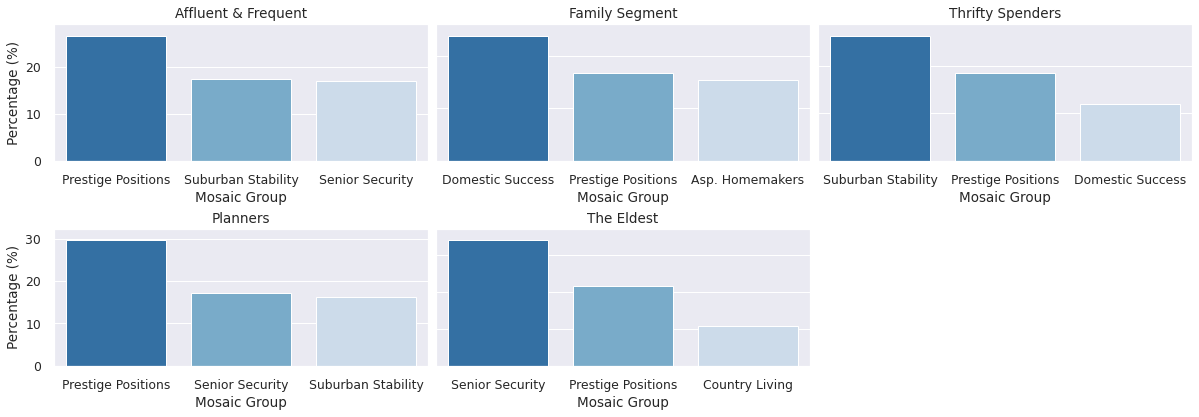

In [61]:
plt.figure(figsize = (17, 6));
for k in range(0, best_k): 
    plt.subplot(2, 3, k+1);
    df_temp = df.loc[df['K-Proto Segment'] == k]
    df_temp.reset_index(inplace = True, drop = True)
    df_temp['Mosaic Group'].replace('Aspiring Homemakers', 'Asp. Homemakers', inplace = True);
    barplt = sns.barplot(x = df_temp['Mosaic Group'].value_counts(ascending = False).index[0:3],
                         y = df_temp['Mosaic Group'].value_counts(normalize = True, ascending = False)[0:3]*100,
                         palette = 'Blues_r');
    plt.ylim(0, plt.gca().get_ylim()[1]*1.04)
    plt.title(clusters_dict[k]);
    plt.xlabel('Mosaic Group');
    if(k%3 == 0):
      plt.ylabel('Percentage (%)');
    else:
      plt.ylabel('');
      barplt.set_yticklabels([]);
plt.tight_layout(w_pad = -1, h_pad = 0.5);
plt.savefig("cluster_results_MosiacGroups.jpeg",
            bbox_inches ="tight",
            pad_inches = 0.1,
            face_color = 'grey',
            edge_color = 'white',
            transparent = False,
            orientation ='landscape');

**`Distribution of Mosaic Types Among Clusters`**

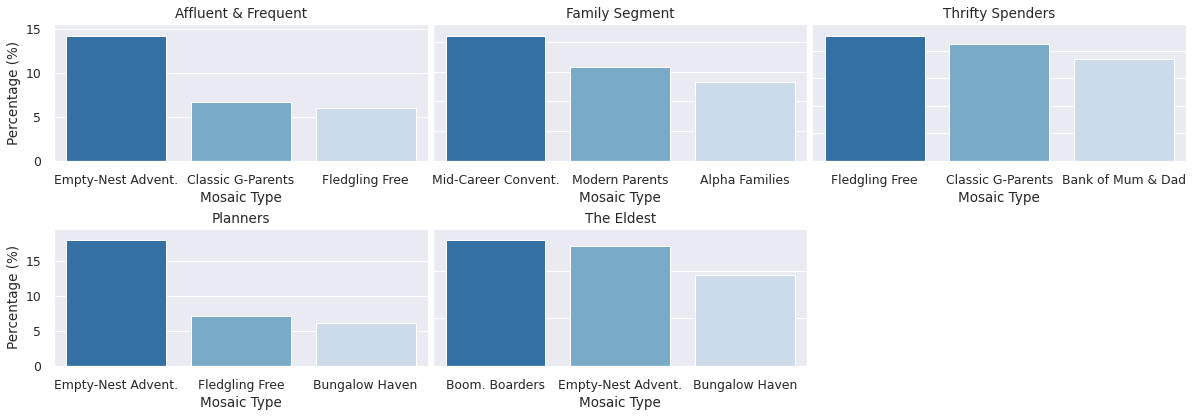

In [62]:
plt.figure(figsize = (17, 6));
for k in range(0, best_k): 
    plt.subplot(2, 3, k+1);
    df_temp = df.loc[df['K-Proto Segment'] == k]
    df_temp.reset_index(inplace = True, drop = True)
    df_temp['Mosaic Type'].replace(['Empty-Nest Adventure', 'Mid-Career Convention', 'Bank of Mum and Dad', 
                                    'Boomerang Boarders', 'Classic Grandparents'], 
                                    ['Empty-Nest Advent.', 'Mid-Career Convent.', 'Bank of Mum & Dad', 
                                     'Classic G-Parents', 'Boom. Boarders'],
                                    inplace = True);
    barplt = sns.barplot(x = df_temp['Mosaic Type'].value_counts(ascending = False).index[0:3],
                         y = df_temp['Mosaic Type'].value_counts(normalize = True, ascending = False)[0:3]*100,
                         palette = 'Blues_r');
    plt.ylim(0, plt.gca().get_ylim()[1]*1.04)
    plt.title(clusters_dict[k]);
    plt.xlabel('Mosaic Type');
    if(k%3 == 0):
      plt.ylabel('Percentage (%)');
    else:
      plt.ylabel('');
      barplt.set_yticklabels([]);
plt.tight_layout(w_pad = -0.9, h_pad = 0.5);
plt.savefig("cluster_results_MosaicTypes.jpeg",
            bbox_inches ="tight",
            pad_inches = 0.1,
            face_color = 'grey',
            edge_color = 'white',
            transparent = False,
            orientation ='landscape');

**`Distribution of Fare Types Among Clusters`**

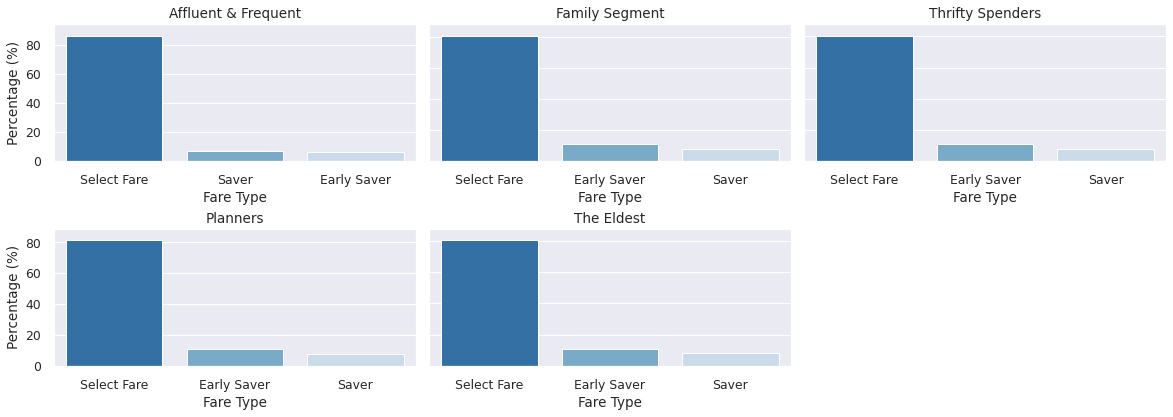

In [63]:
plt.figure(figsize = (16.5, 6));
for k in range(0, best_k): 
    plt.subplot(2, 3, k+1);
    df_temp = df.loc[df['K-Proto Segment'] == k]
    df_temp.reset_index(inplace = True, drop = True)
    barplt = sns.barplot(x = df_temp['Faretype'].value_counts(ascending = False).index[0:3],
                         y = df_temp['Faretype'].value_counts(normalize = True, ascending = False)[0:3]*100,
                         palette = 'Blues_r');
    plt.ylim(0, plt.gca().get_ylim()[1]*1.04)
    plt.title(clusters_dict[k]);
    plt.xlabel('Fare Type');
    if(k%3 == 0):
      plt.ylabel('Percentage (%)');
    else:
      plt.ylabel('');
      barplt.set_yticklabels([]);
plt.tight_layout(w_pad = 1, h_pad = 0.5);
plt.savefig("cluster_results_MosaicTypes.jpeg",
            bbox_inches ="tight",
            pad_inches = 0.1,
            face_color = 'grey',
            edge_color = 'white',
            transparent = False,
            orientation ='landscape');
plt.savefig("cluster_results_faretypes.jpeg",
            bbox_inches ="tight",
            pad_inches = 0.1,
            face_color = 'grey',
            edge_color = 'white',
            transparent = False,
            orientation ='landscape');  

**`Distribution of Cabin Types Among Clusters`**

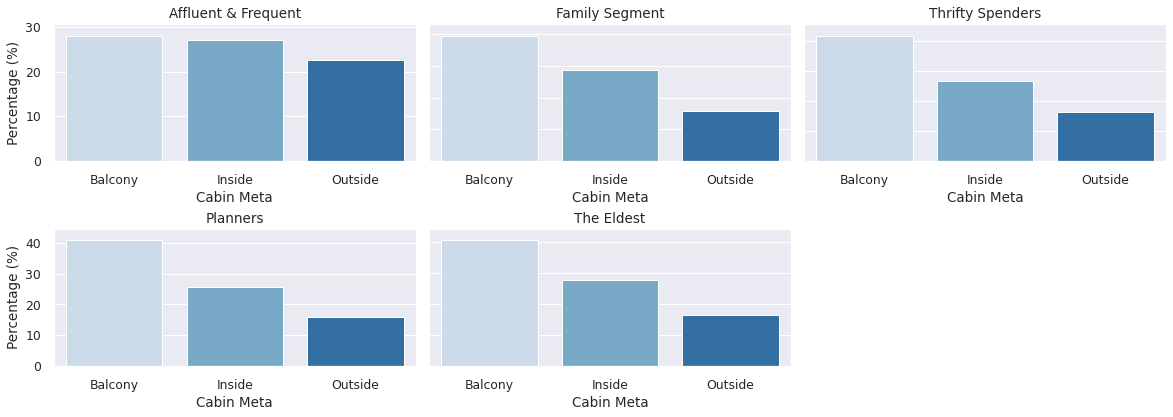

In [64]:
plt.figure(figsize = (16.5, 6));
for k in range(0, best_k): 
    plt.subplot(2, 3, k+1);
    df_temp = df.loc[df['K-Proto Segment'] == k]
    df_temp.reset_index(inplace = True, drop = True)
    barplt = sns.barplot(x = df_temp['Cabin'].value_counts(ascending = False).index[0:3],
                         y = df_temp['Cabin'].value_counts(normalize = True, ascending = False)[0:3]*100,
                         palette = 'Blues');
    plt.ylim(0, plt.gca().get_ylim()[1]*1.04)
    plt.title(clusters_dict[k]);
    plt.xlabel('Cabin Meta');
    if(k%3 == 0):
      plt.ylabel('Percentage (%)');
    else:
      plt.ylabel('');
      barplt.set_yticklabels([]);
plt.tight_layout(w_pad = 1, h_pad = 0.5);
plt.savefig("cluster_results_cabins.jpeg",
            bbox_inches ="tight",
            pad_inches = 0.1,
            face_color = 'grey',
            edge_color = 'white',
            transparent = False,
            orientation ='landscape');

**`Distribution of Cruise Experience Groups Among Clusters`**

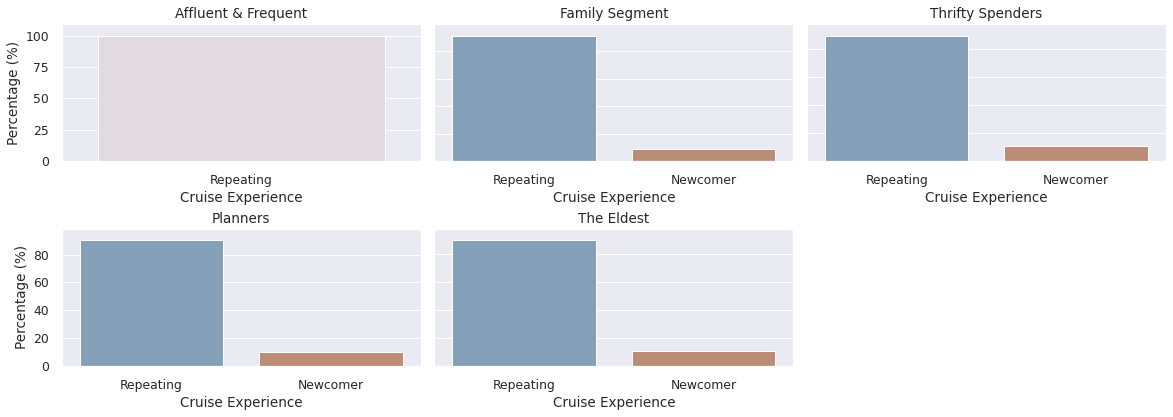

In [65]:
plt.figure(figsize = (16.5, 6));
for k in range(0, best_k): 
    plt.subplot(2, 3, k+1);
    df_temp = df.loc[df['K-Proto Segment'] == k]
    df_temp.reset_index(inplace = True, drop = True)
    barplt = sns.barplot(x = df_temp['Cruise Experience'].value_counts(ascending = False).index,
                         y = df_temp['Cruise Experience'].value_counts(normalize = True, ascending = False)*100,
                         palette = 'twilight_shifted');
    plt.ylim(0, plt.gca().get_ylim()[1]*1.04)
    plt.title(clusters_dict[k]);
    plt.xlabel('Cruise Experience');
    if(k%3 == 0):
      plt.ylabel('Percentage (%)');
    else:
      plt.ylabel('');
      barplt.set_yticklabels([]);
plt.tight_layout(w_pad = 1, h_pad = 0.5);
plt.savefig("cluster_results_CruiseExperience.jpeg",
            bbox_inches ="tight",
            pad_inches = 0.1,
            face_color = 'grey',
            edge_color = 'white',
            transparent = False,
            orientation ='landscape');

**`Distribution of Regions Among Clusters`**

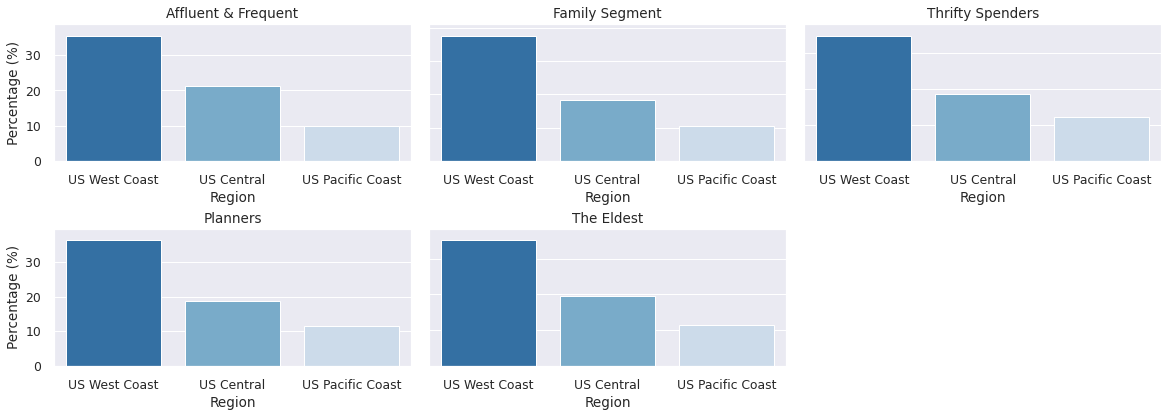

In [66]:
plt.figure(figsize = (16.5, 6));
for k in range(0, best_k): 
    plt.subplot(2, 3, k+1);
    df_temp = df.loc[df['K-Proto Segment'] == k]
    df_temp.reset_index(inplace = True, drop = True)
    barplt = sns.barplot(x = df_temp['Region'].value_counts(ascending = False).index[0:3],
                         y = df_temp['Region'].value_counts(normalize = True, ascending = False)[0:3]*100,
                         palette = 'Blues_r');
    plt.ylim(0, plt.gca().get_ylim()[1]*1.04)
    plt.title(clusters_dict[k]);
    plt.xlabel('Region');
    if(k%3 == 0):
      plt.ylabel('Percentage (%)');
    else:
      plt.ylabel('');
      barplt.set_yticklabels([]);
plt.tight_layout(w_pad = 1, h_pad = 0.5);
plt.savefig("cluster_results_regions.jpeg",
            bbox_inches ="tight",
            pad_inches = 0.1,
            face_color = 'grey',
            edge_color = 'white',
            transparent = False,
            orientation ='landscape');

**`Distribution of Methods of Contact Among Clusters`**

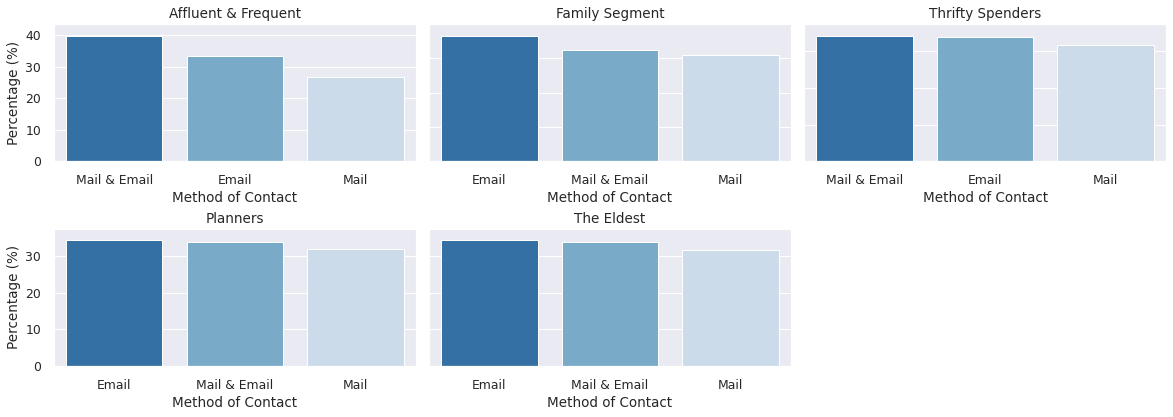

In [67]:
plt.figure(figsize = (16.5, 6));
for k in range(0, best_k): 
    plt.subplot(2, 3, k+1);
    df_temp = df.loc[df['K-Proto Segment'] == k]
    df_temp.reset_index(inplace = True, drop = True)
    barplt = sns.barplot(x = df_temp['Contactability'].value_counts(ascending = False).index,
                         y = df_temp['Contactability'].value_counts(normalize = True, ascending = False)*100,
                         palette = 'Blues_r');
    plt.ylim(0, plt.gca().get_ylim()[1]*1.04)
    plt.title(clusters_dict[k]);
    plt.xlabel('Method of Contact');
    if(k%3 == 0):
      plt.ylabel('Percentage (%)');
    else:
      plt.ylabel('');
      barplt.set_yticklabels([]);
plt.tight_layout(w_pad = 1, h_pad = 0.5);
plt.savefig("cluster_results_contactability.jpeg",
            bbox_inches ="tight",
            pad_inches = 0.1,
            face_color = 'grey',
            edge_color = 'white',
            transparent = False,
            orientation ='landscape');

**`Distribution of Embarkment Months Among Clusters`**

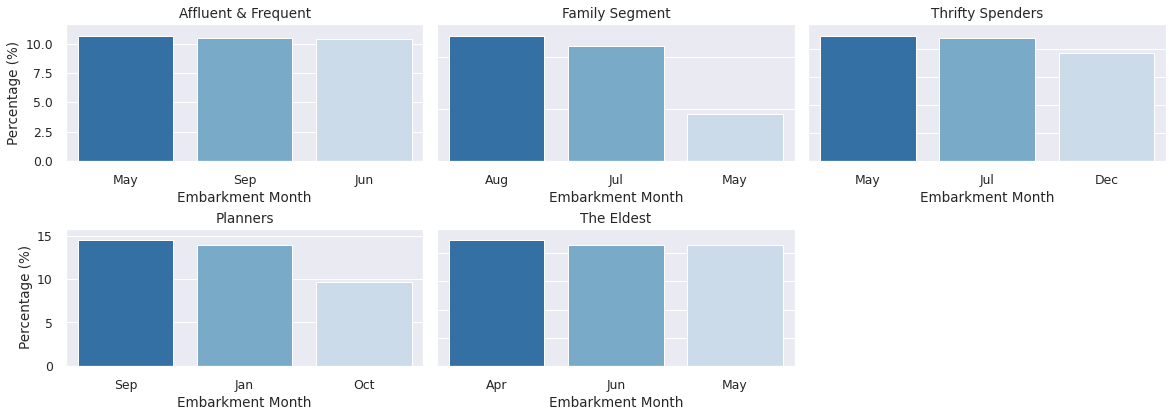

In [68]:
plt.figure(figsize = (16.5, 6));
for k in range(0, best_k): 
    plt.subplot(2, 3, k+1);
    df_temp = df.loc[df['K-Proto Segment'] == k]
    df_temp.reset_index(inplace = True, drop = True)
    barplt = sns.barplot(x = df_temp['Month Name'].value_counts(ascending = False).index[0:3],
                         y = df_temp['Month Name'].value_counts(normalize = True, ascending = False)[0:3]*100,
                         palette = 'Blues_r');
    plt.ylim(0, plt.gca().get_ylim()[1]*1.04)
    plt.title(clusters_dict[k]);
    plt.xlabel('Embarkment Month');
    if(k%3 == 0):
      plt.ylabel('Percentage (%)');
    else:
      plt.ylabel('');
      barplt.set_yticklabels([]);
plt.tight_layout(w_pad = 1, h_pad = 0.5);
plt.savefig("cluster_results_EmbarkmentMonth.jpeg",
            bbox_inches ="tight",
            pad_inches = 0.1,
            face_color = 'grey',
            edge_color = 'white',
            transparent = False,
            orientation ='landscape');